In [2]:
import sddk
import pandas as pd
import requests
pd.options.display.max_columns = 1000 # to see all columns
import json
import re
import geopandas as gpd
import warnings
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
warnings.filterwarnings('ignore')
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import geoplot as gplt
import networkx as nx
import numbers

In [45]:
plt.rcParams['figure.dpi'] = 300

# Orbis - Meeks

In [4]:
# read orbis nodes (directly from Meeks)

url = "https://raw.githubusercontent.com/emeeks/orbis_v2/master/sites_extended.csv"
orbis_sites_meeks = pd.read_csv(url)
orbis_sites_meeks = gpd.GeoDataFrame(orbis_sites_meeks, geometry=gpd.points_from_xy(orbis_sites_meeks["x"], orbis_sites_meeks["y"])) #, crs={"init": "epsg:3857"})
orbis_sites_meeks.head(5)

id          label  rank       x       y  cost  target       province  \
0  50001      Abodiacum    60  10.909  47.909     0       0         Raetia   
1  50002  Ad fl. Tigrim    60  42.191  37.341     0       0        Armenia   
2  50003  Ad Publicanos    60   6.374  45.671     0       0    Narbonensis   
3  50004  Ad Tricesimum    60  13.215  46.157     0       0         Italia   
4  50005        Ad Aras    60  -0.977  38.736     0       0  Tarraconensis   

    modern                   geometry  
0  Germany  POINT (10.90900 47.90900)  
1   Turkey  POINT (42.19100 37.34100)  
2   France   POINT (6.37400 45.67100)  
3    Italy  POINT (13.21500 46.15700)  
4    Spain  POINT (-0.97700 38.73600)

In [5]:
#orbis_hanson_gpd.drop(["cost", "target"], axis=1, inplace=True)

In [6]:
# but with valid coordinates
len(orbis_sites_meeks[orbis_sites_meeks["x"] !=0])

670

In [17]:
orbis_sites_meeks_ids = orbis_sites_meeks["id"].tolist()

<AxesSubplot:>

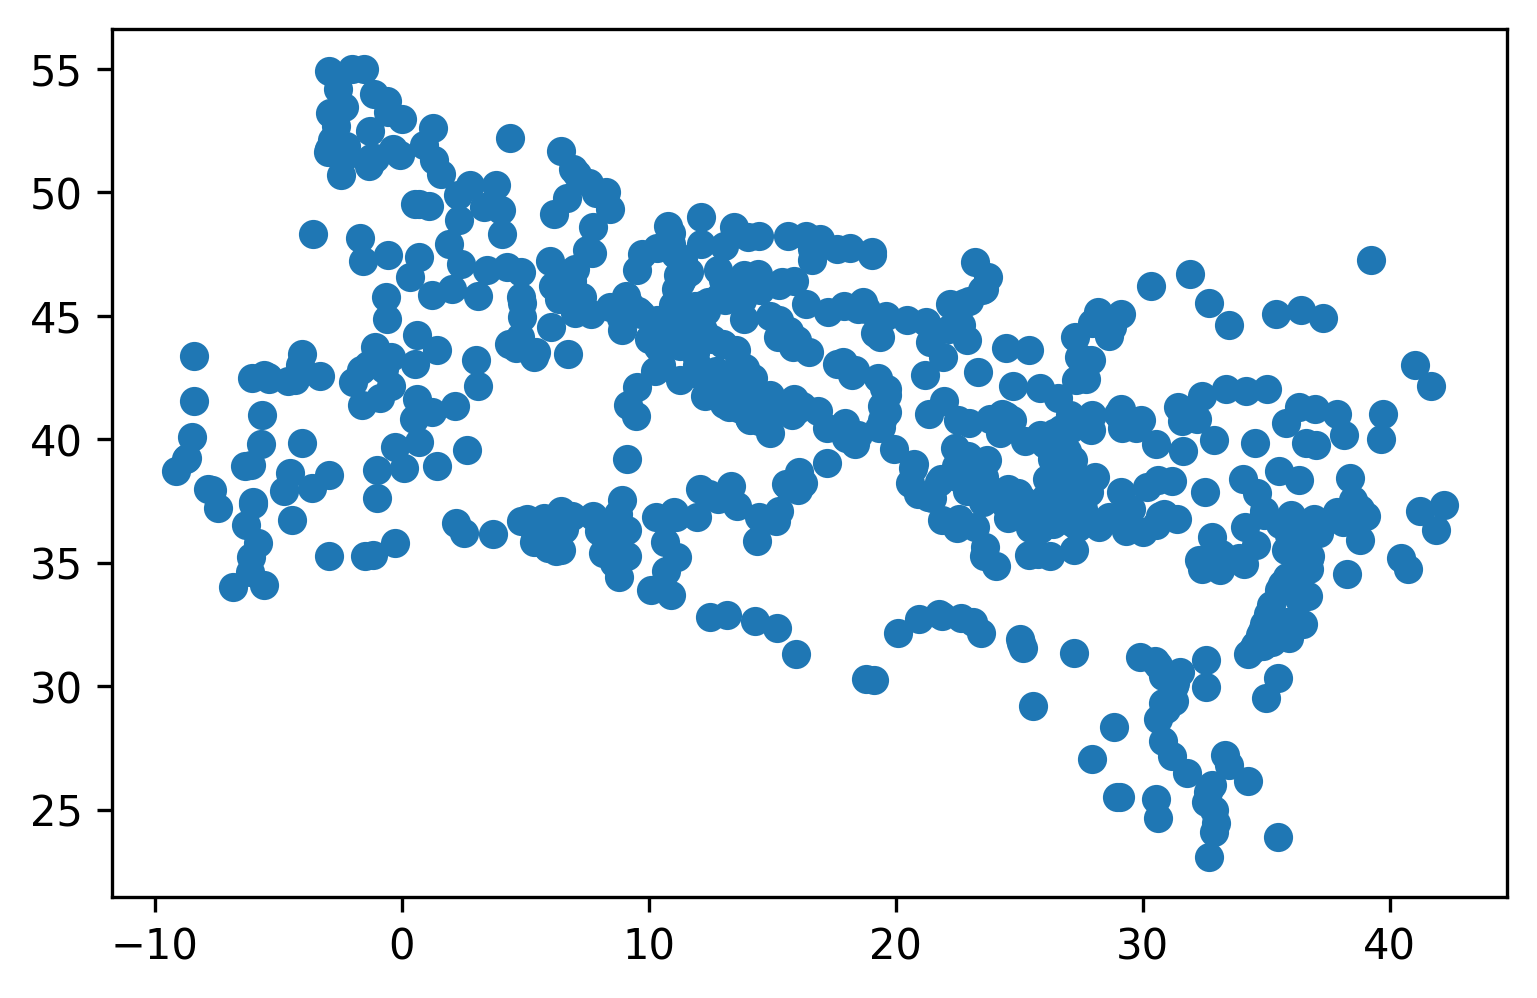

In [46]:
orbis_sites_meeks.plot()

In [9]:
orbis_sites_meeks_ids = orbis_sites_meeks["id"].tolist()

# Orbis - Fousek et al.

In [10]:
url = "https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0208744.s006"
orbis_sites_fousek = pd.read_csv(url, skiprows=5)
orbis_sites_fousek.head()

objectid            label  XCOORD  YCOORD                          PLPATH
0     50002    Ad fl. Tigrim  37.325  42.196     /places/874296/ad-fl-tigrim
1     50209  Iulia Concordia  45.757  12.844  /places/393441/iulia-concordia
2     50327             Roma  41.892  12.486             /places/423025/roma
3     50319       Praetorium  31.500  15.500       /places/364003/praetorium
4     50294         Patavium  45.410  11.877         /places/393473/patavium

In [11]:
len(orbis_sites_fousek)

648

In [12]:
# but with valid coordinates
len(orbis_sites_fousek[orbis_sites_fousek["XCOORD"] !=0])

573

In [13]:
# nodes only in fousek
orbis_sites_fousek[~orbis_sites_fousek["objectid"].isin(orbis_sites_meeks_ids)]

objectid          label  XCOORD  YCOORD  \
357     50317         Portus  41.780  12.258   
399     50522        Aufidus  41.360  16.210   
502     50572        Rheneia  37.420  25.210   
504     50457  Kriou Metopon   0.000   0.000   
622     50786          Kerea  25.750  36.750   
624     50789      Lebinthos  26.459  37.005   
625     50790          Leros  23.625  37.875   
627     50792        Mykonos  25.370  37.440   
637     51177     Noviomagus   0.000   0.000   
638     51176           Isca   0.000   0.000   
640     51175          Venta   0.000   0.000   
641     51173      Moridunum   0.000   0.000   
642     51172          Ratae   0.000   0.000   
644     51171       Cironium   0.000   0.000   
646     51170     Durovernum   0.000   0.000   

                                     PLPATH  
357                   /places/423012/portus  
399                                     NaN  
502                                     NaN  
504                                     NaN  
622  http://pleiades.stoa.org/places/599708  
624  http://pleiades.stoa.org/places/599755  
625  http://pleiades.stoa.org/places/580012  
627  http://pleiades.stoa.org/places/599808  
637                                     NaN  
638                                     NaN  
640                                     NaN  
641                                     NaN  
642                                     NaN  
644                                     NaN  
646                                     NaN

In [14]:
url = "https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0208744.s007"
orbis_edges_fousek = pd.read_csv(url, skiprows=3)
orbis_edges_fousek.head()

from     to      cost
0  50176  50250  1.161604
1  50176  50183  1.545437
2  50176  50031  3.694511
3  50177  50173  0.931266
4  50177  50109  0.957881

In [15]:
# unique nodes in edges
orbis_edgenodes = list(set(orbis_edges_fousek["from"].tolist() + orbis_edges_fousek["from"].tolist()))
len(orbis_edgenodes)

648

In [19]:
len([id for id in orbis_sites_meeks_ids if id in orbis_edgenodes])

633

In [20]:
def check_if_meeks(row):
    if (row["from"] in orbis_sites_meeks_ids) and (row["to"] in orbis_sites_meeks_ids):
        return True
    else:
        return False
orbis_edges_fousek["meeks?"] = orbis_edges_fousek.apply(lambda row: check_if_meeks(row), axis=1)

In [21]:
len(orbis_edges_fousek)

2394

In [22]:
orbis_edges_fousek_filtered = orbis_edges_fousek[orbis_edges_fousek["meeks?"]]
len(orbis_edges_fousek_filtered)

2301

In [23]:
orbis_edges_fousek_filtered[orbis_edges_fousek_filtered["from"]== orbis_edges_fousek_filtered["to"]]

from     to       cost  meeks?
17    50180  50180   1.787326    True
45    50186  50186   1.283211    True
51    50187  50187   5.310780    True
64    50191  50191  11.792798    True
93    50200  50200   1.606444    True
...     ...    ...        ...     ...
2323  50158  50158   8.015738    True
2326  50159  50159   2.301107    True
2331  50160  50160   0.278807    True
2350  50163  50163   1.410308    True
2375  50170  50170   0.965508    True

[105 rows x 4 columns]

# Orbis - Stanford

In [48]:
url = "https://stacks.stanford.edu/file/druid:mn425tz9757/orbis_edges_0514.csv"
orbis_edges_stanford = pd.read_csv(url)
len(orbis_edges_stanford)

2208

In [49]:
len(np.unique(orbis_edges_stanford[["source", "target"]]))

678

In [50]:
url = "https://stacks.stanford.edu/file/druid:mn425tz9757/orbis_nodes_0514.csv"
orbis_sites_stanford = pd.read_csv(url)
len(orbis_sites_stanford)

678

In [51]:
orbis_sites_stanford.head(5)

id            label       x       y
0  50002    Ad fl. Tigrim  37.325  42.196
1  50209  Iulia Concordia  45.757  12.844
2  50327             Roma  41.892  12.486
3  50319       Praetorium  31.500  15.500
4  50294         Patavium  45.410  11.877

In [52]:
orbis_sites_stanford = gpd.GeoDataFrame(orbis_sites_stanford, geometry=gpd.points_from_xy(orbis_sites_stanford["y"], orbis_sites_stanford["x"]))

<AxesSubplot:>

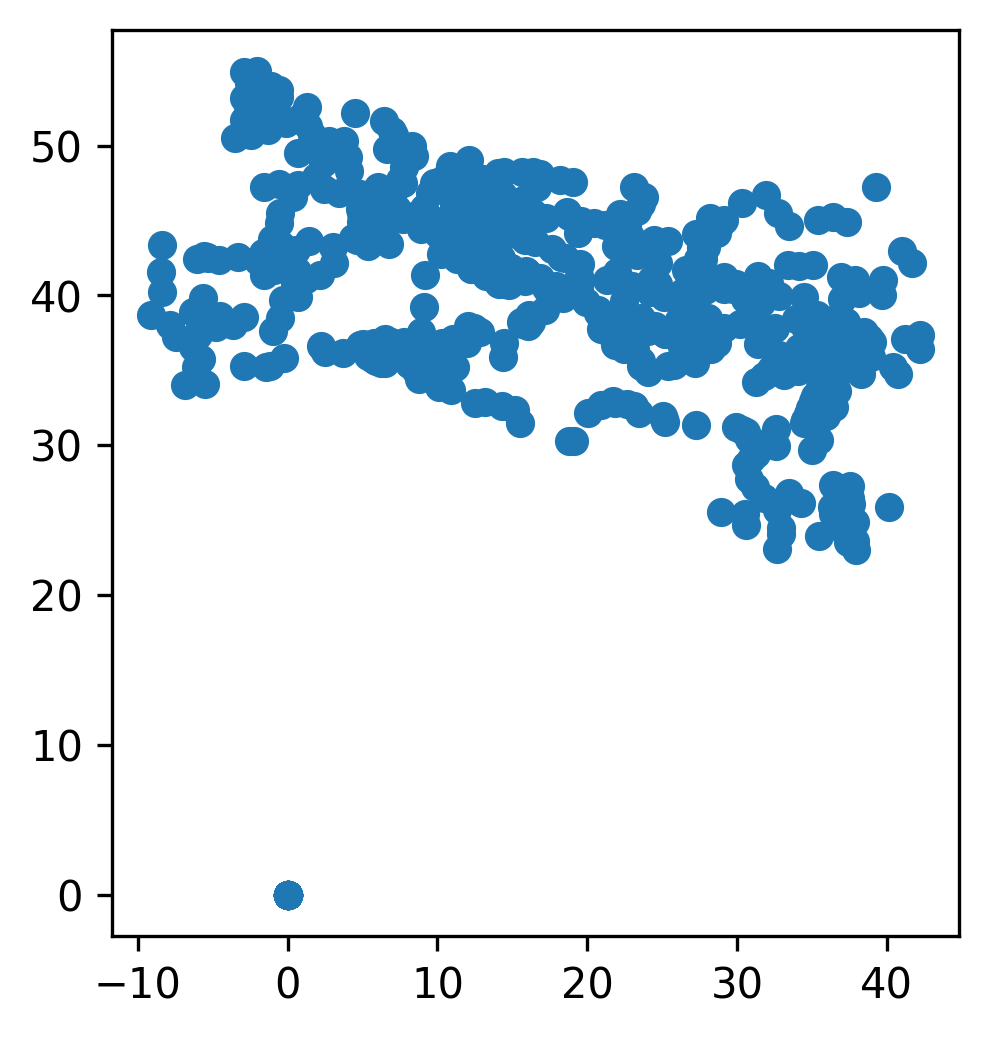

In [53]:
orbis_sites_stanford.plot()

In [54]:
len(orbis_sites_stanford[orbis_sites_stanford["x"].isnull()])

55

In [55]:
# checkingh an alternative method
len(orbis_sites_stanford[orbis_sites_stanford["x"].apply(lambda val: np.isnan(val))])

55

In [56]:
# number of sites with valid geography
len(orbis_sites_stanford[(orbis_sites_stanford["x"].apply(lambda val: isinstance(val, numbers.Number))) & (orbis_sites_stanford["x"] !=0)])

629

In [57]:
# number of sites in Meeks with valid geography
len(orbis_sites_meeks[(orbis_sites_meeks["x"].apply(lambda val: isinstance(val, numbers.Number))) & (orbis_sites_meeks["x"] !=0)])

670

In [58]:
# select modern countries with Latin
# (a preliminary check)
countries_latin = ["Tunisia", "Italy", "Switzerland", "France", 'Spain', 'United Kingdom', 'Romania', 'Croatia', 'Montenegro', 'Bosnia & Herzegovina', 'Serbia', 'Germany', 'Belgium', 'Netherlands', 'Portugal', 'Slovenia', 'Algeria', 'Morocco', 'Kosovo', 'Austria', 'Hungary']
# use these countries to filter for cities
orbis_sites_meeks_latin = orbis_sites_meeks[orbis_sites_meeks["modern"].isin(countries_latin)]
len(orbis_sites_meeks_latin)

380

In [59]:
def get_coordinate(site_id, coor_value, coor_col):
    try: site_id = int(site_id)
    except: pass
    if isinstance(coor_value, numbers.Number):
        if (np.isnan(coor_value)) | (coor_value==0):
            new_val = orbis_sites_meeks[orbis_sites_meeks["id"]==site_id][coor_col]
            if len(new_val) > 0:
                coor_value = new_val.tolist()[0]
            else:
                coor_value = None
        return coor_value
    else:
        return None

orbis_sites_stanford["x"] = orbis_sites_stanford.apply(lambda row: get_coordinate(row["id"], row["x"], "y"), axis=1)
orbis_sites_stanford["y"] = orbis_sites_stanford.apply(lambda row: get_coordinate(row["id"], row["y"], "x"), axis=1)

In [60]:
orbis_sites_stanford[~orbis_sites_stanford["id"].isin(orbis_sites_meeks_ids)]

id          label       x       y                   geometry
360  50317         Portus  41.780  12.258  POINT (12.25800 41.78000)
402  50522        Aufidus  41.360  16.210  POINT (16.21000 41.36000)
529  50572        Rheneia  37.420  25.210  POINT (25.21000 37.42000)
531  50457  Kriou Metopon     NaN     NaN    POINT (0.00000 0.00000)
659  50786          Kerea  25.750  36.750  POINT (36.75000 25.75000)
661  50789      Lebinthos  26.459  37.005  POINT (37.00500 26.45900)
662  50790          Leros  23.625  37.875  POINT (37.87500 23.62500)
664  50792        Mykonos  25.370  37.440  POINT (37.44000 25.37000)

In [61]:
orbis_sites_stanford[orbis_sites_stanford["y"].isnull()]

id          label   x   y                 geometry
531  50457  Kriou Metopon NaN NaN  POINT (0.00000 0.00000)

In [62]:
# is it in Fousek's datataset? - yes, but without coordinates...
orbis_sites_fousek[orbis_sites_fousek["objectid"]==50457]

objectid          label  XCOORD  YCOORD PLPATH
504     50457  Kriou Metopon     0.0     0.0    NaN

In [63]:
# is it in Meeks' dataset? - no...
orbis_sites_meeks[orbis_sites_meeks["id"]==50457]

Empty GeoDataFrame
Columns: [id, label, rank, x, y, cost, target, province, modern, geometry]
Index: []

In [64]:
# geocode manually on the basis of pleiades (https://pleiades.stoa.org/places/589884)
orbis_sites_stanford.at[531, "x"] = 35.2319
orbis_sites_stanford.at[531, "y"] = 23.5896

In [65]:
orbis_sites_stanford[orbis_sites_stanford["id"]==50457]

id          label        x        y                 geometry
531  50457  Kriou Metopon  35.2319  23.5896  POINT (0.00000 0.00000)

In [66]:
# transform into geodataframe for more straihtforward plotting and spatial explorations
orbis_sites_stanford = gpd.GeoDataFrame(orbis_sites_stanford, geometry=gpd.points_from_xy(orbis_sites_stanford["y"], orbis_sites_stanford["x"])) #, crs={"init": "epsg:3857"})

<AxesSubplot:>

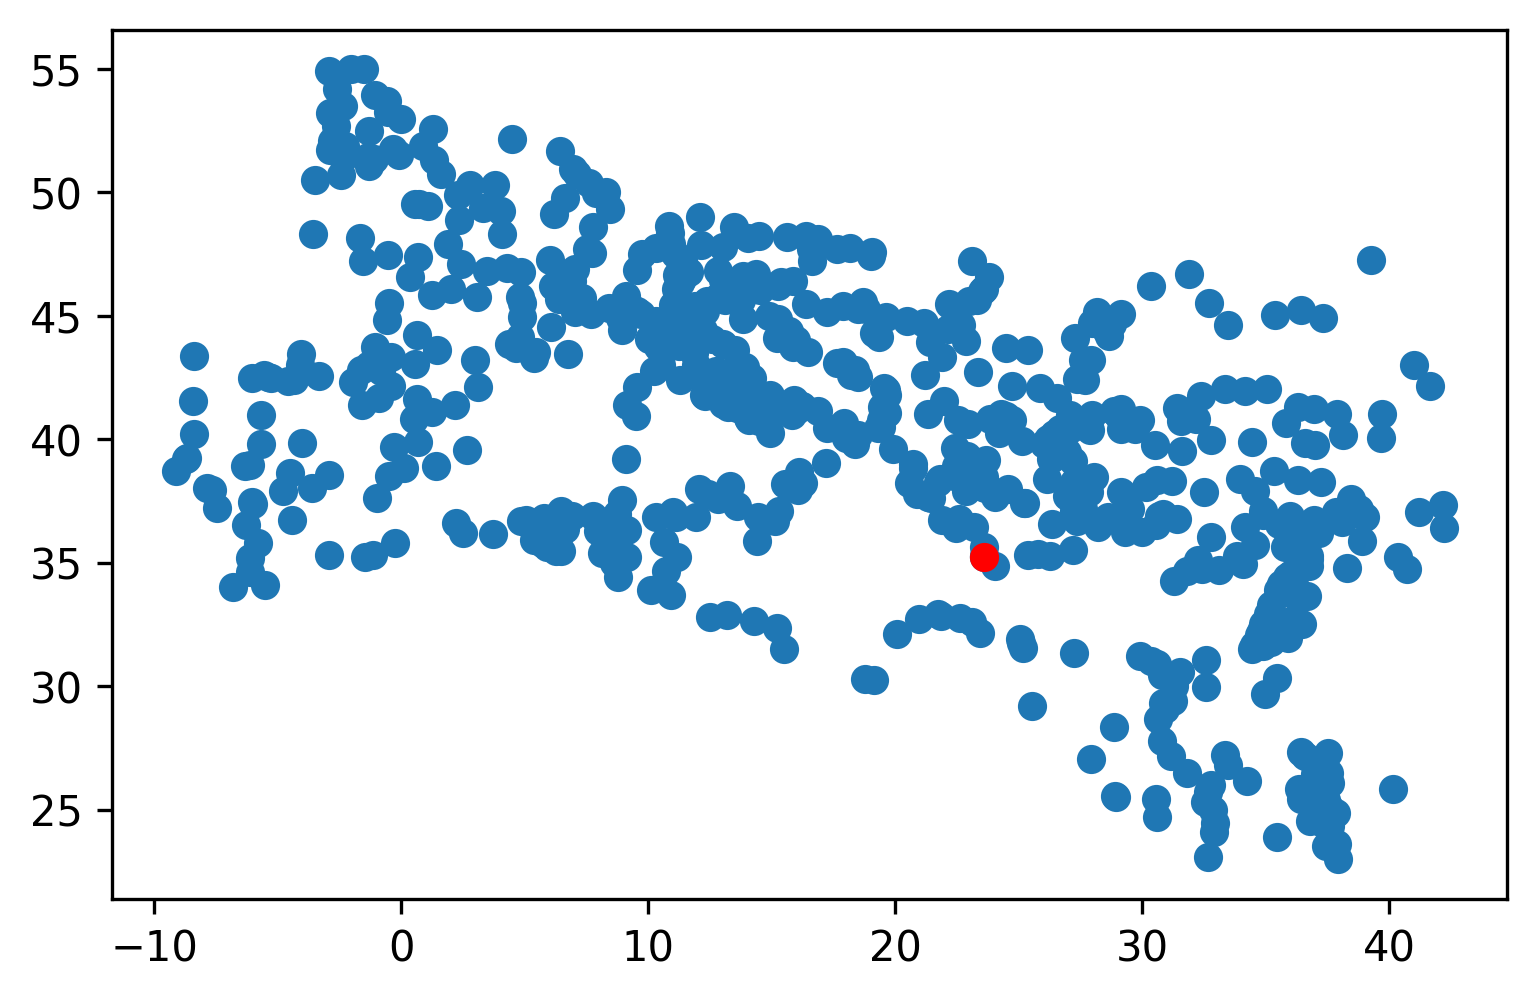

In [67]:
# plot the gdf, with Kriou Metopon on the top
fig, ax = plt.subplots()
orbis_sites_stanford.plot(ax=ax)
orbis_sites_stanford[orbis_sites_stanford["id"]==50457].plot(color="red", ax=ax)

<AxesSubplot:>

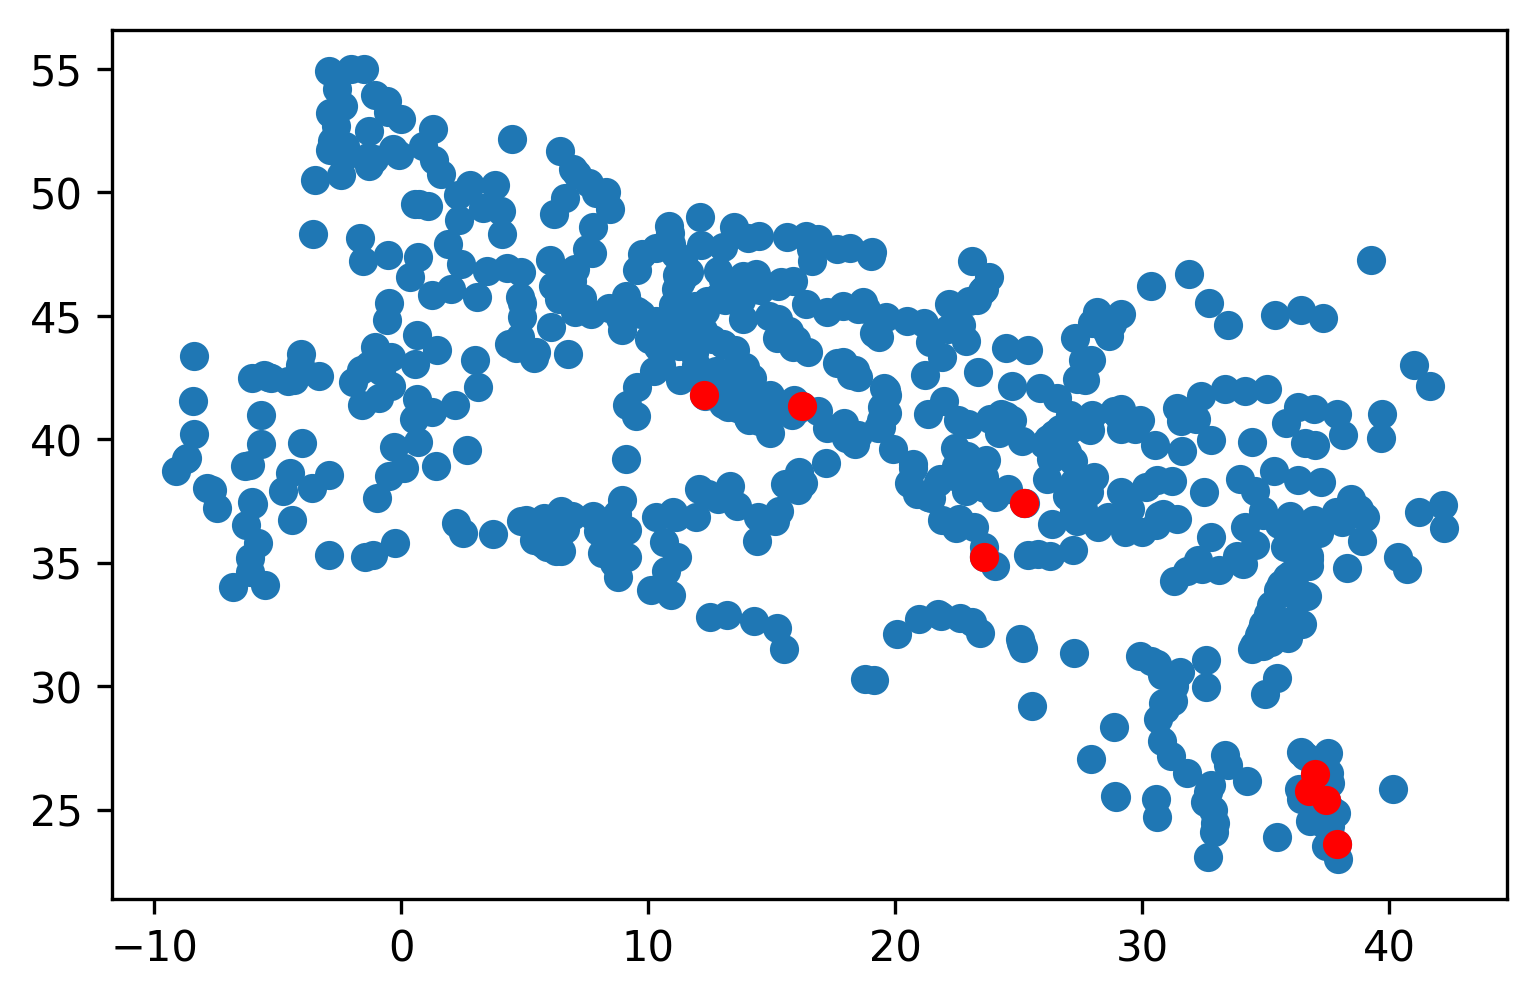

In [68]:
# plot with sites missing in Meeks (red)
fig, ax = plt.subplots()
orbis_sites_stanford.plot(ax=ax)
orbis_sites_stanford[~orbis_sites_stanford["id"].isin(orbis_sites_meeks_ids)].plot(color="red", ax=ax)

In [69]:
# create a network from the edges data
G3 = nx.convert_matrix.from_pandas_edgelist(orbis_edges_stanford, "source", "target")

In [70]:
# add edge attributes to the network

edge_keys = [(s, t) for s,t in zip(orbis_edges_stanford["source"], orbis_edges_stanford["target"])]
edge_values = orbis_edges_stanford[["km", "days", "expense", "type"]].to_dict("records")
edge_dict = dict(zip(edge_keys, edge_values))

nx.set_edge_attributes(G3, edge_dict)

In [71]:
G3.edges(data=True)

EdgeDataView([(50001, 50056, {'km': 54.539, 'days': 1.818, 'expense': 1.909, 'type': 'road'}), (50001, 50100, {'km': 50.135, 'days': 1.671, 'expense': 1.755, 'type': 'road'}), (50001, 50293, {'km': 65.681, 'days': 2.189, 'expense': 2.299, 'type': 'road'}), (50001, 50473, {'km': 225.368, 'days': 7.512, 'expense': 7.888, 'type': 'road'}), (50056, 50314, {'km': 126.177, 'days': 4.206, 'expense': 4.416, 'type': 'road'}), (50056, 50370, {'km': 32.01, 'days': 1.067, 'expense': 1.12, 'type': 'road'}), (50100, 50083, {'km': 58.819, 'days': 1.961, 'expense': 2.059, 'type': 'road'}), (50293, 50408, {'km': 52.83, 'days': 1.761, 'expense': 1.849, 'type': 'road'}), (50473, 50315, {'km': 25.576, 'days': 0.853, 'expense': 0.895, 'type': 'road'}), (50002, 50275, {'km': 92.174, 'days': 3.072, 'expense': 3.226, 'type': 'road'}), (50275, 50119, {'km': 280.885, 'days': 2.341, 'expense': 0.955, 'type': 'fastdown'}), (50275, 50161, {'km': 225.509, 'days': 7.517, 'expense': 7.893, 'type': 'road'}), (50275, 5

In [72]:
nodes_dict = dict(zip(orbis_sites_stanford["id"].tolist(), orbis_sites_stanford[["label", "x", "y"]].to_dict("records")))
nx.set_node_attributes(G3, nodes_dict)

In [73]:
G3.nodes(data=True)

NodeDataView({50001: {'label': 'Abodiacum', 'x': 47.91, 'y': 10.91}, 50056: {'label': 'Augusta Vindelicum', 'x': 48.365, 'y': 10.895}, 50100: {'label': 'Cambodunum', 'x': 47.727, 'y': 10.327}, 50293: {'label': 'Parthanum', 'x': 47.492, 'y': 11.086}, 50473: {'label': 'Maiensis Statio', 'x': 46.659, 'y': 11.169}, 50002: {'label': 'Ad fl. Tigrim', 'x': 37.325, 'y': 42.196}, 50275: {'label': 'Nisibis', 'x': 37.067, 'y': 41.216}, 50003: {'label': 'Ad Publicanos', 'x': 45.667, 'y': 6.387}, 50052: {'label': 'Augusta Praetoria', 'x': 45.737, 'y': 7.314}, 50182: {'label': 'Genava', 'x': 46.203, 'y': 6.139}, 50004: {'label': 'Ad Tricesimum', 'x': 46.158, 'y': 13.216}, 50034: {'label': 'Aquileia', 'x': 45.768, 'y': 13.365}, 50747: {'label': 'x', 'x': 46.371, 'y': 13.128}, 50005: {'label': 'Ad Aras', 'x': 38.5, 'y': -0.5}, 50108: {'label': 'Carthago Nova', 'x': 37.606, 'y': -0.991}, 50248: {'label': 'Mariana', 'x': 38.547, 'y': -2.927}, 50332: {'label': 'Saguntum', 'x': 39.68, 'y': -0.279}, 50006:

In [74]:
# extract positions dictionary for plotting
positions = dict(zip(orbis_sites_stanford["id"].tolist(), list(np.column_stack((orbis_sites_stanford["y"], orbis_sites_stanford["x"])))))
positions

{50002: array([42.196, 37.325]),
 50209: array([12.844, 45.757]),
 50327: array([12.486, 41.892]),
 50319: array([15.5, 31.5]),
 50294: array([11.877, 45.41 ]),
 50322: array([14.122, 40.824]),
 50009: array([15.088, 41.152]),
 50330: array([ 1.332, 51.294]),
 50008: array([34.974, 29.664]),
 50326: array([15.644, 38.109]),
 50328: array([-2.938, 35.292]),
 50329: array([ 6.906, 36.883]),
 50001: array([10.91, 47.91]),
 50003: array([ 6.387, 45.667]),
 50005: array([-0.5, 38.5]),
 50289: array([-5.297, 42.475]),
 50039: array([33.95 , 38.402]),
 50323: array([12.197, 44.416]),
 50290: array([38.286, 34.768]),
 50030: array([23.58 , 46.077]),
 50035: array([19.05 , 47.564]),
 50331: array([12.485, 32.806]),
 50356: array([20.466, 44.802]),
 50359: array([19.61 , 44.966]),
 50332: array([-0.279, 39.68 ]),
 50041: array([ 7.744, 48.583]),
 50333: array([-6.833, 34.015]),
 50360: array([-4.518, 38.645]),
 50364: array([38.914, 35.864]),
 50365: array([-1.344, 51.412]),
 50286: array([12.28

In [75]:
# load orbis routes from Meeks' github (for closer examination of the spatial element)
url = "https://raw.githubusercontent.com/emeeks/orbis_v2/master/new_routes.geojson"
orbis_routes = gpd.read_file(url)

In [76]:
# what is there?
orbis_routes.head(5)

sid     tid         t      e      s                           m  \
0  250311  250383   coastal  0.073  0.732  1,10,11,12,2,3,4,5,6,7,8,9   
1  350073  350452  overseas  0.208  2.082  1,10,11,12,2,3,4,5,6,7,8,9   
2  350094  350452  overseas  0.233  2.332  1,10,11,12,2,3,4,5,6,7,8,9   
3  250312  250335   coastal  0.042  0.418  1,10,11,12,2,3,4,5,6,7,8,9   
4  350107  350286  overseas  0.355  3.550  1,10,11,12,2,3,4,5,6,7,8,9   

                                            geometry  
0  LINESTRING (13.84000 44.86900, 13.76400 44.891...  
1  LINESTRING (35.52100 33.89800, 35.46400 33.891...  
2  LINESTRING (34.89800 32.50800, 34.86400 32.491...  
3  LINESTRING (14.48400 40.74800, 14.36400 40.791...  
4  LINESTRING (10.31200 36.84600, 10.36400 36.891...

In [77]:
### # pelagios provinces - to be used as a base map in our plots
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = gpd.read_file(url)
pleiades_regions.head(5)

name                                     uri  \
0           Lusitania    http://pleiades.stoa.org/places/1101   
1            Byzacena  http://pleiades.stoa.org/places/991345   
2          Viennensis  http://pleiades.stoa.org/places/992074   
3  Lycia et Pamphylia  http://pleiades.stoa.org/places/981530   
4               Savia  http://pleiades.stoa.org/places/991357   

                                            geometry  
0  POLYGON ((-7.31057 37.19663, -7.32457 37.19556...  
1  MULTIPOLYGON (((11.01815 34.62424, 11.00879 34...  
2  POLYGON ((4.62344 45.60642, 4.71224 45.60876, ...  
3  MULTIPOLYGON (((29.62331 36.07470, 29.61295 36...  
4  POLYGON ((18.10598 45.77203, 18.10654 45.71079...

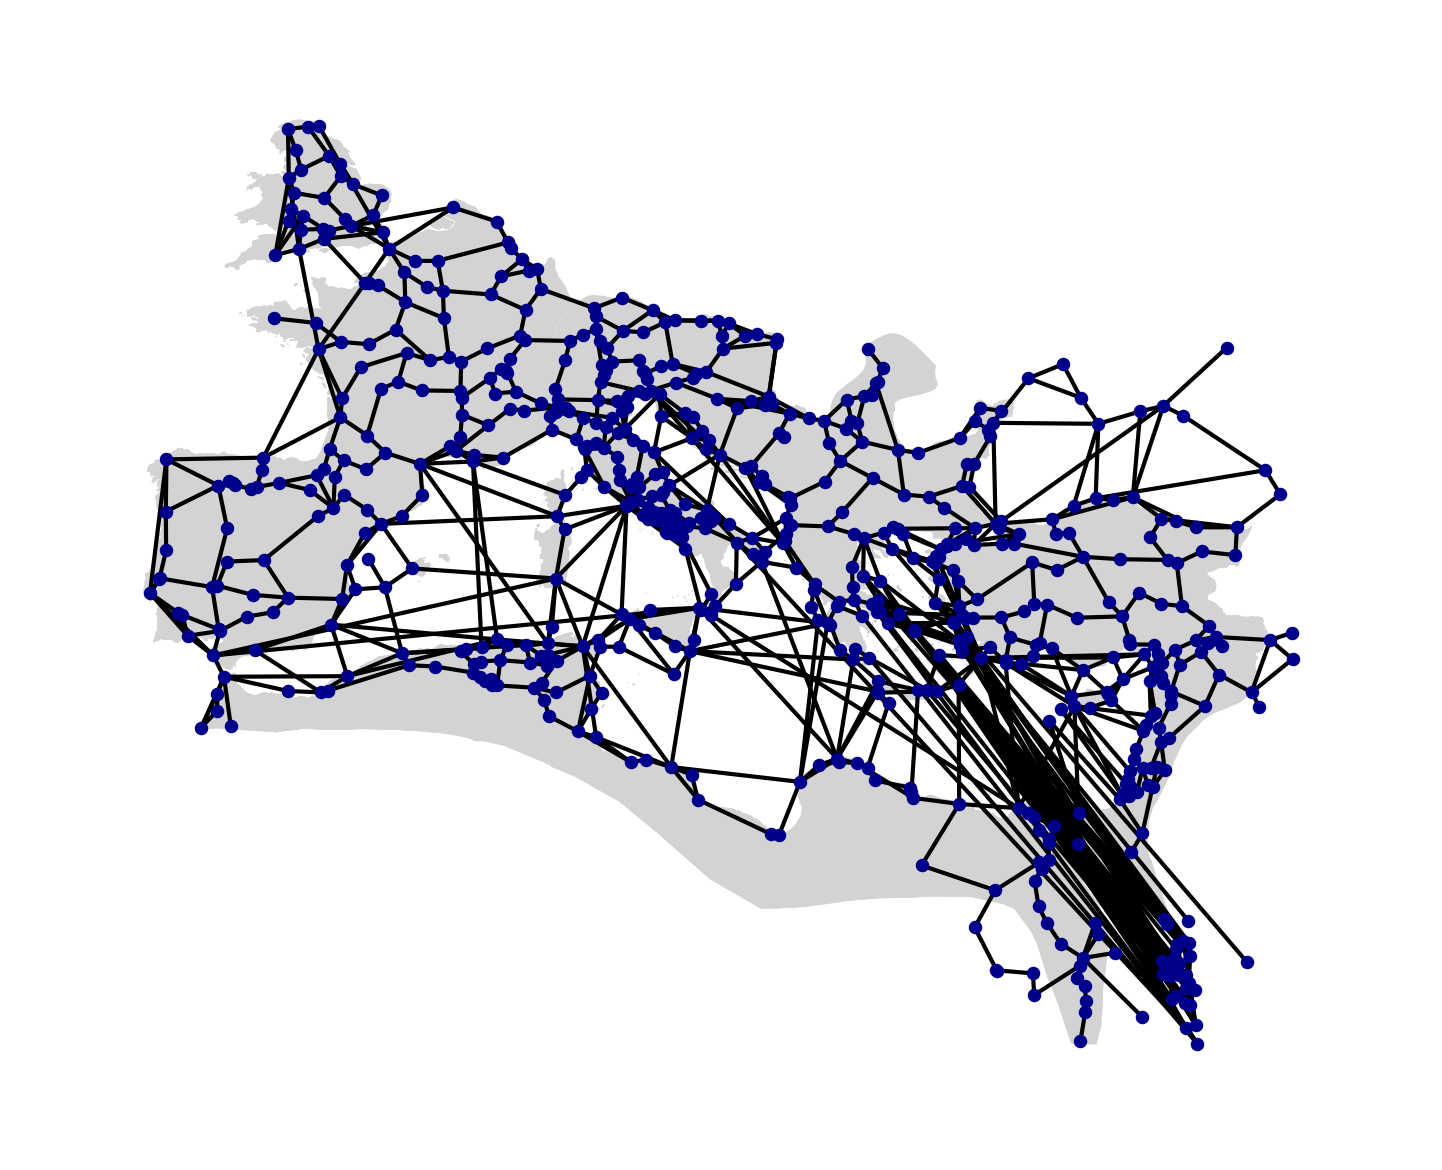

In [78]:
# look at the network with spatially anchored sites

fig, ax = plt.subplots(figsize=[5.2, 4], tight_layout=True)
#markersizes = np.sqrt(np.array(cities_pop["pop_est"].tolist()) / 1000)
pleiades_regions.plot(color="lightgray", ax=ax)

#orbis_routes.plot(ax=ax, linewidth=0.4)
nx.draw(G3, positions, with_labels=False, node_size=5, node_color="darkblue", node_shape="o", linewidths=1, ax=ax)


#orbis_sites_stanford.plot(markersize=1, color="green", ax=ax, alpha=0.5)
ax.set_axis_off()

In [79]:
# what's wrong with the sites in the bottom right corner?
# why are they so strangely connected with the rest of the network?

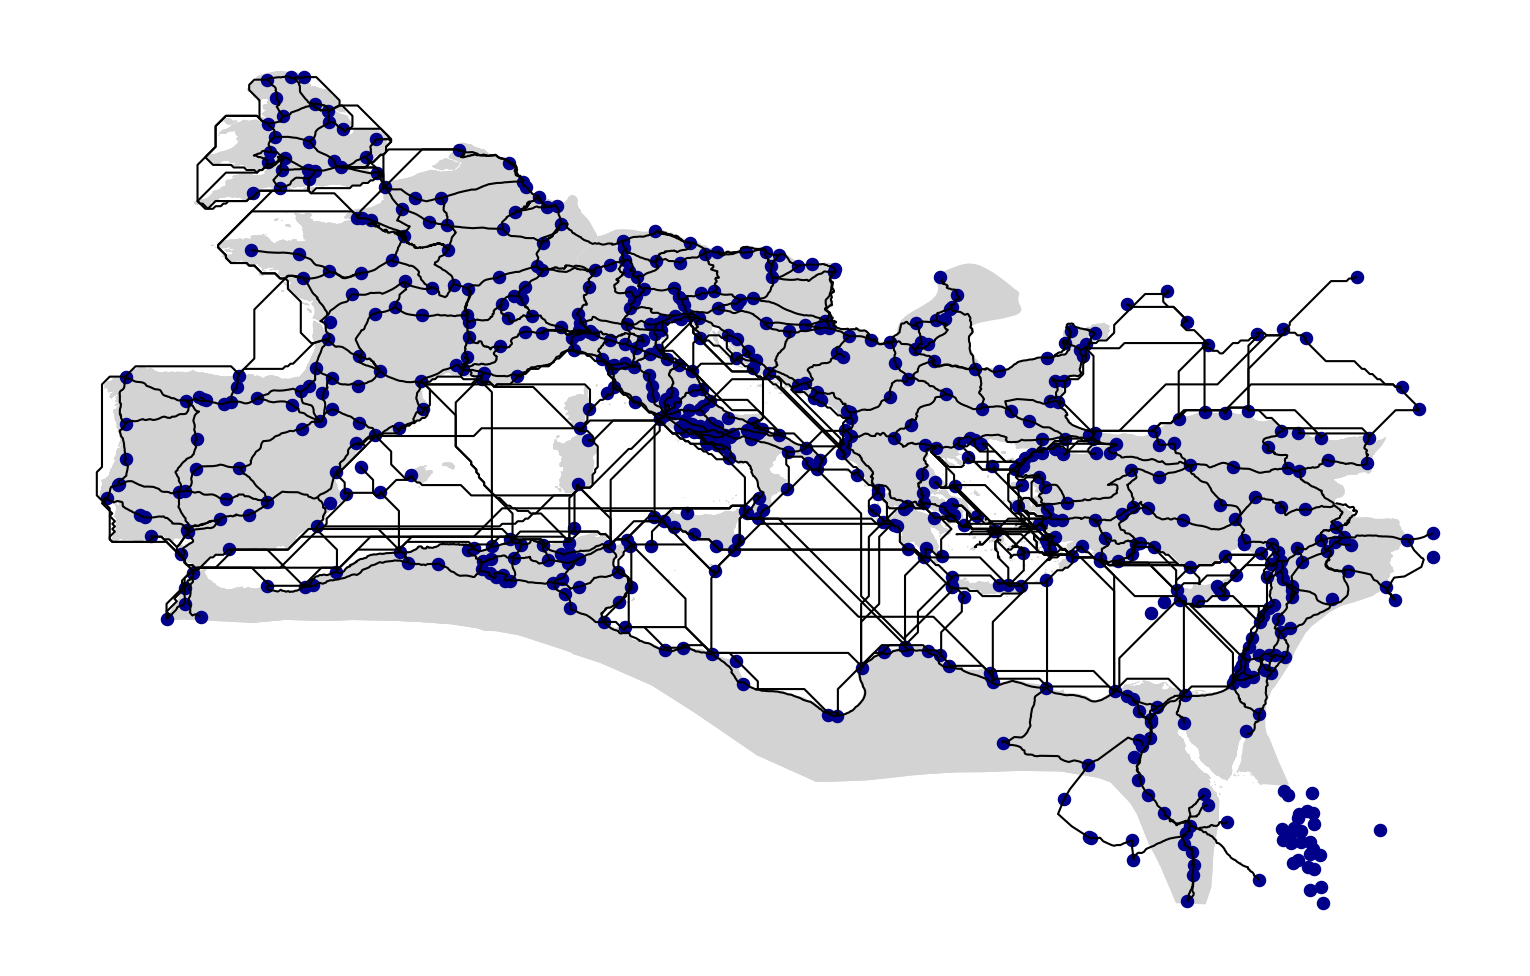

In [80]:
# how does it look like when we look at the routes instead?

fig, ax = plt.subplots(figsize=[5.2, 4], tight_layout=True)
#markersizes = np.sqrt(np.array(cities_pop["pop_est"].tolist()) / 1000)
pleiades_regions.plot(color="lightgray", ax=ax)

orbis_routes.plot(ax=ax, color="black", linewidth=0.5)

orbis_sites_stanford.plot(markersize=5, color="darkblue", ax=ax)
ax.set_axis_off()

In [81]:
# ok, these sites lie completely out of the routes network
# there is obviously something wrong with the coordinates
# most probably, they are simply inverse (x for y, y for x)

# but how to choose for what sites to make the exchange?
# let's use the coordinates from meeks whereever available

def get_coordinate(site_id, coor_value, coor_col):
    if site_id in orbis_sites_meeks_ids:
        coor_value = orbis_sites_meeks[orbis_sites_meeks["id"]==site_id][coor_col].tolist()[0]
    return coor_value

# remember that Meeks has inverse naming!
orbis_sites_stanford["x"] = orbis_sites_stanford.apply(lambda row: get_coordinate(row["id"], row["x"], "y"), axis=1)
orbis_sites_stanford["y"] = orbis_sites_stanford.apply(lambda row: get_coordinate(row["id"], row["y"], "x"), axis=1)

In [82]:
# update the positions
positions = dict(zip(orbis_sites_stanford["id"].tolist(), list(np.column_stack((orbis_sites_stanford["y"], orbis_sites_stanford["x"])))))

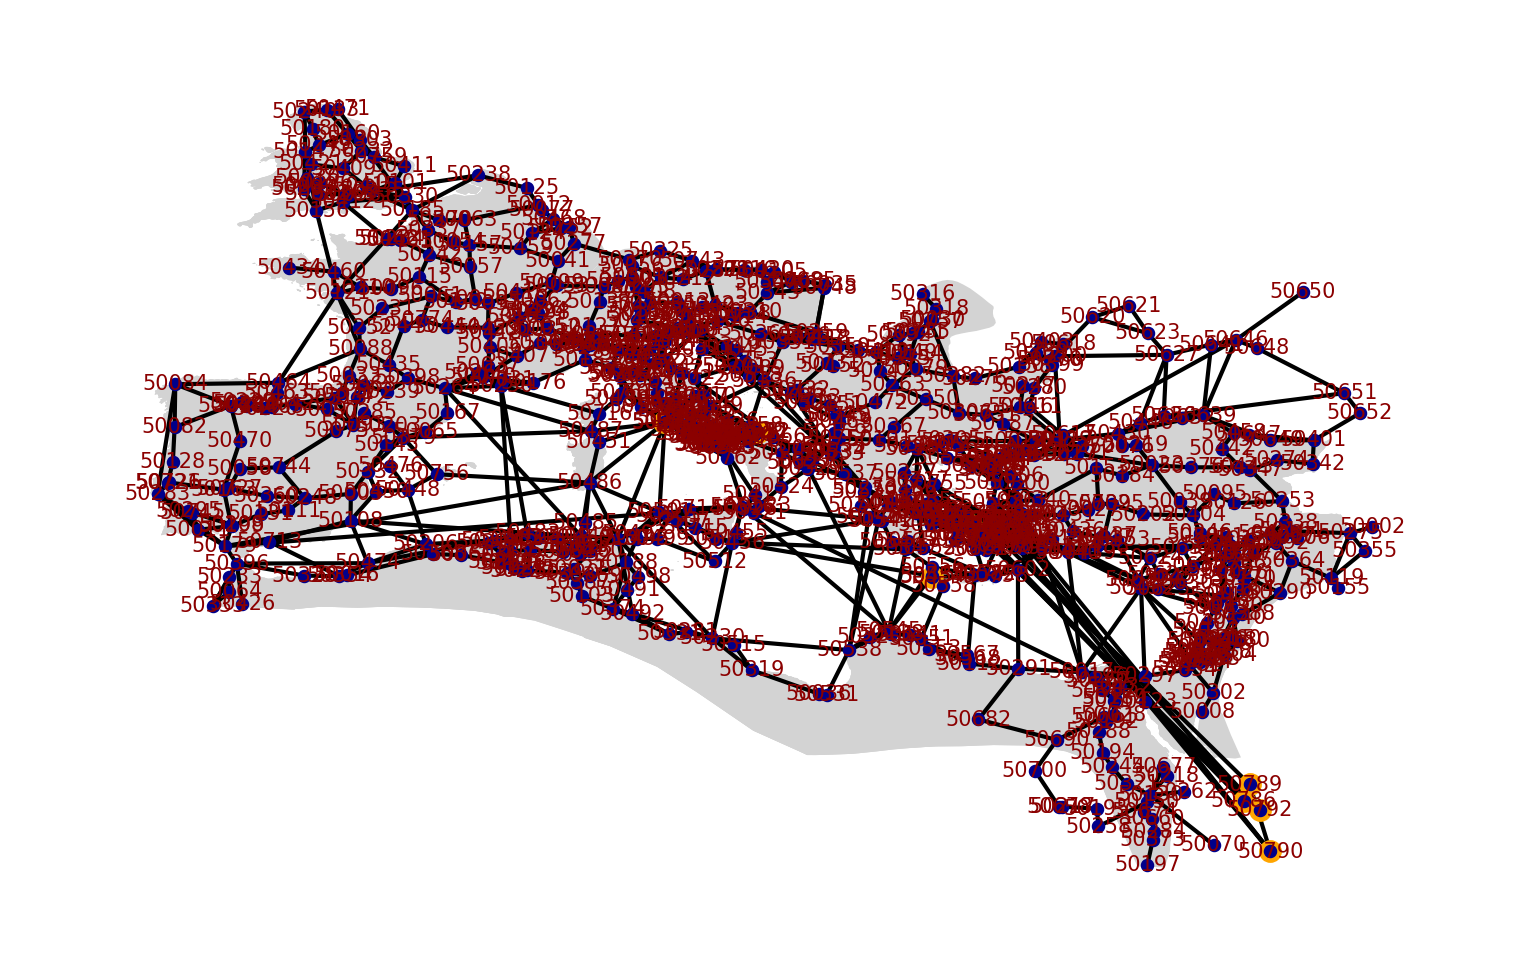

In [83]:
# and make the geospatial network plot again

fig, ax = plt.subplots(figsize=[5.2, 4], tight_layout=True)
#markersizes = np.sqrt(np.array(cities_pop["pop_est"].tolist()) / 1000)
pleiades_regions.plot(color="lightgray", ax=ax)

#orbis_routes.plot(ax=ax, linewidth=0.4)
nx.draw(G3, positions, with_labels=True, node_size=5, node_color="darkblue", node_shape="o", linewidths=1, font_size=5, font_color="darkred", ax=ax)

orbis_sites_stanford[~orbis_sites_stanford["id"].isin(orbis_sites_meeks_ids)].plot(color="orange", label="id", markersize=20, ax=ax)

#orbis_sites_stanford.plot(markersize=1, color="green", ax=ax, alpha=0.5)
ax.set_axis_off()

In [84]:
# there are still 4 sites in this strange location
# all of them are missing missing in the Meeks' version of the dataset
# (see the last four lines here)
orbis_sites_stanford[~orbis_sites_stanford["id"].isin(orbis_sites_meeks_ids)]

id          label        x        y                   geometry
360  50317         Portus  41.7800  12.2580  POINT (12.25800 41.78000)
402  50522        Aufidus  41.3600  16.2100  POINT (16.21000 41.36000)
529  50572        Rheneia  37.4200  25.2100  POINT (25.21000 37.42000)
531  50457  Kriou Metopon  35.2319  23.5896  POINT (23.58960 35.23190)
659  50786          Kerea  25.7500  36.7500  POINT (36.75000 25.75000)
661  50789      Lebinthos  26.4590  37.0050  POINT (37.00500 26.45900)
662  50790          Leros  23.6250  37.8750  POINT (37.87500 23.62500)
664  50792        Mykonos  25.3700  37.4400  POINT (37.44000 25.37000)

In [85]:
# let's manually exchange their x,y values
orbis_sites_stanford.at[659, "y"], orbis_sites_stanford.at[659, "x"]  = 25.7500, 36.7500
orbis_sites_stanford.at[661, "y"], orbis_sites_stanford.at[661, "x"]  = 26.4590, 37.0050
orbis_sites_stanford.at[662, "y"], orbis_sites_stanford.at[662, "x"]  = 23.6250, 37.8750
orbis_sites_stanford.at[664, "y"], orbis_sites_stanford.at[664, "x"]  = 25.3700, 37.4400
# update the gdf geometry column using these new values
orbis_sites_stanford = gpd.GeoDataFrame(orbis_sites_stanford, geometry=gpd.points_from_xy(orbis_sites_stanford["y"], orbis_sites_stanford["x"])) #, crs={"init": "epsg:3857"})
# update the positions dict
positions = dict(zip(orbis_sites_stanford["id"].tolist(), list(np.column_stack((orbis_sites_stanford["y"], orbis_sites_stanford["x"])))))

In [86]:
orbis_sites_stanford.reset_index().drop("index", axis=1, inplace=True)

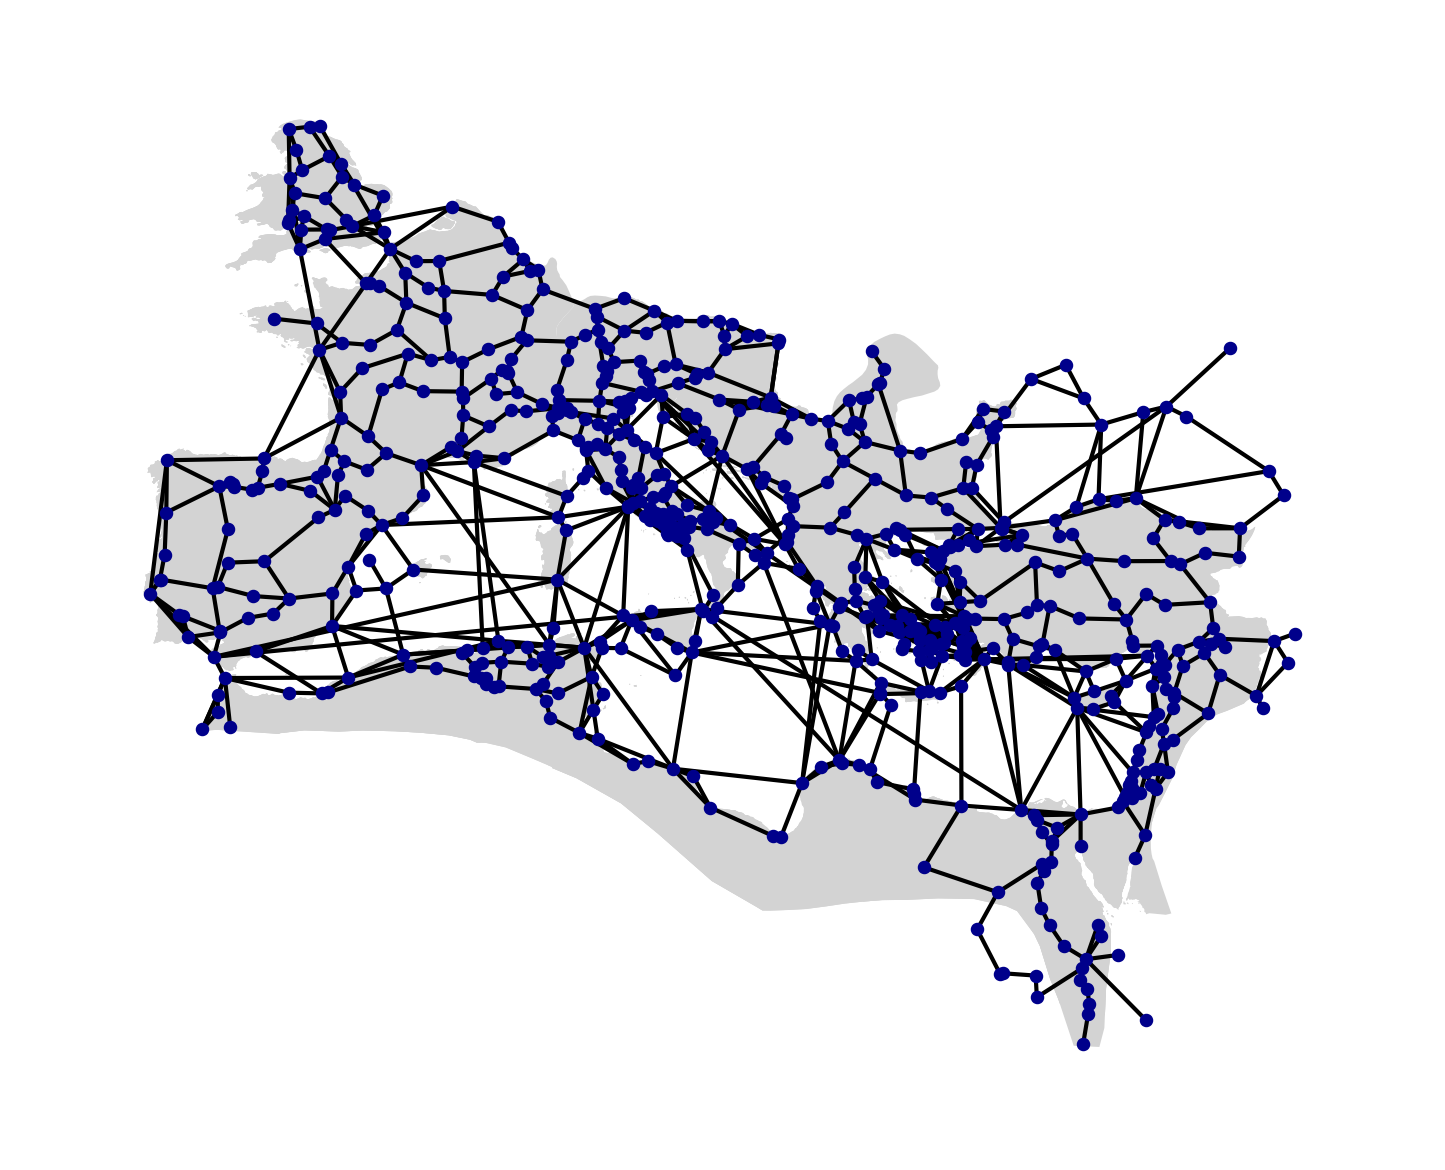

In [87]:
fig, ax = plt.subplots(figsize=[5.2, 4], tight_layout=True)
pleiades_regions.plot(color="lightgray", ax=ax)

nx.draw(G3, positions, with_labels=False, node_size=5, node_color="darkblue", node_shape="o", linewidths=1, ax=ax)
ax.set_axis_off()

In [88]:
# create the whole network again, to be sure that everywhere is the correct x,y values etc.
G3 = nx.convert_matrix.from_pandas_edgelist(orbis_edges_stanford, "source", "target")

# add edge attributes
edge_keys = [(s, t) for s,t in zip(orbis_edges_stanford["source"], orbis_edges_stanford["target"])]
edge_values = orbis_edges_stanford[["km", "days", "expense", "type"]].to_dict("records")
edge_dict = dict(zip(edge_keys, edge_values))
nx.set_edge_attributes(G3, edge_dict)

# add node attributes
nodes_dict = dict(zip(orbis_sites_stanford["id"].tolist(), orbis_sites_stanford[["label", "x", "y"]].to_dict("records")))
nx.set_node_attributes(G3, nodes_dict)

In [89]:
pleiades_regions_union = pleiades_regions.unary_union

In [90]:
orbis_routes_ids = list(np.unique(orbis_routes[["sid", "tid"]]))

In [91]:
orbis_sites_outRE = orbis_sites_stanford[
    ~(orbis_sites_stanford.within(pleiades_regions_union)) 
    & ~(orbis_sites_stanford["id"].isin(orbis_routes_ids))
                    ]["id"].tolist()

In [92]:
len(orbis_sites_outRE)

70

In [93]:
len(G3.nodes)

678

In [94]:
# create the whole network again, to be sure that everywhere is the correct x,y values etc.
G_RE = nx.convert_matrix.from_pandas_edgelist(orbis_edges_stanford, "source", "target")

# add edge attributes
edge_keys = [(s, t) for s,t in zip(orbis_edges_stanford["source"], orbis_edges_stanford["target"])]
edge_values = orbis_edges_stanford[["km", "days", "expense", "type"]].to_dict("records")
edge_dict = dict(zip(edge_keys, edge_values))
nx.set_edge_attributes(G_RE, edge_dict)

# add node attributes
nodes_dict = dict(zip(orbis_sites_stanford["id"].tolist(), orbis_sites_stanford[["label", "x", "y"]].to_dict("records")))
nx.set_node_attributes(G_RE, nodes_dict)

In [95]:
# we can focus on sites within the empire, once needed....
G_RE.remove_nodes_from(orbis_sites_outRE)

In [96]:
nx.is_connected(G_RE)

False

In [97]:
# it is disconnected, so we cannot use it like this.

# import roman cities according to hanson



In [3]:
# import roman cities according to hanson

url = "https://sciencedata.dk//shared/c89a5bd90c45fd07fb57fefc11b12ab0?download"
roman_cities = gpd.read_file(url)

In [7]:
cities_big = roman_cities[roman_cities["pop_est"]>=30000]
cities_middle = roman_cities[(roman_cities["pop_est"]>1000) & (roman_cities["pop_est"]<30000)]
cities_minor = roman_cities[roman_cities["pop_est"]<=1000]

print(len(cities_big), cities_big["pop_est"].sum())
print(len(cities_middle), cities_middle["pop_est"].sum())
print(len(cities_minor), cities_minor["pop_est"].sum())

68 4641352.0
690 4942985.0
630 630000.0


In [99]:
routes_ids = list(np.unique(orbis_routes[["sid", "tid"]]))
nodes_without_routes = G3.nodes - routes_ids
#G3.remove_nodes_from(nodes_without_routes)

In [100]:
len(G3.nodes)

678

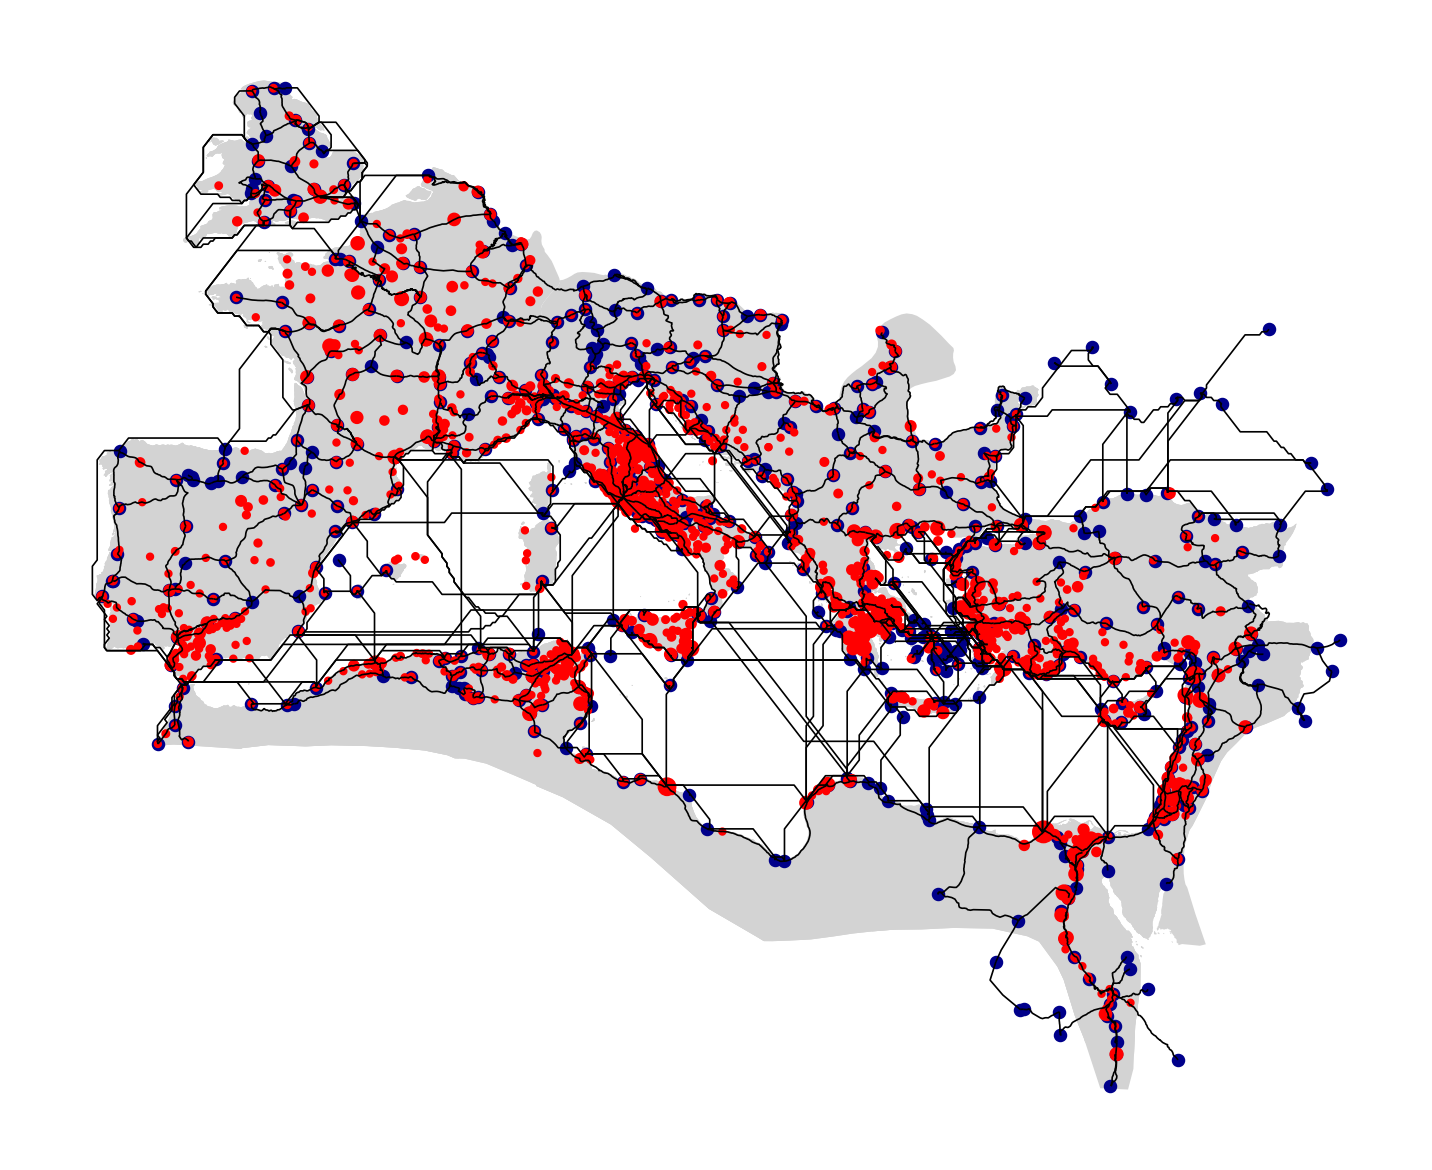

In [101]:
# save for future usage
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=[5.2, 4], tight_layout=True)
pleiades_regions.plot(color="lightgray", ax=ax)

orbis_routes.plot(ax=ax, linewidth=0.4, color="black")

orbis_sites_stanford.plot(markersize=5, color="darkblue", ax=ax)

markersizes = np.sqrt(np.array(roman_cities["pop_est"].tolist()) / 1000)
roman_cities.plot(markersize=markersizes, ax=ax, color="red")


ax.set_axis_off()
#ax.set_xlim(-10, 41)
#ax.set_ylim(23, 55.5)

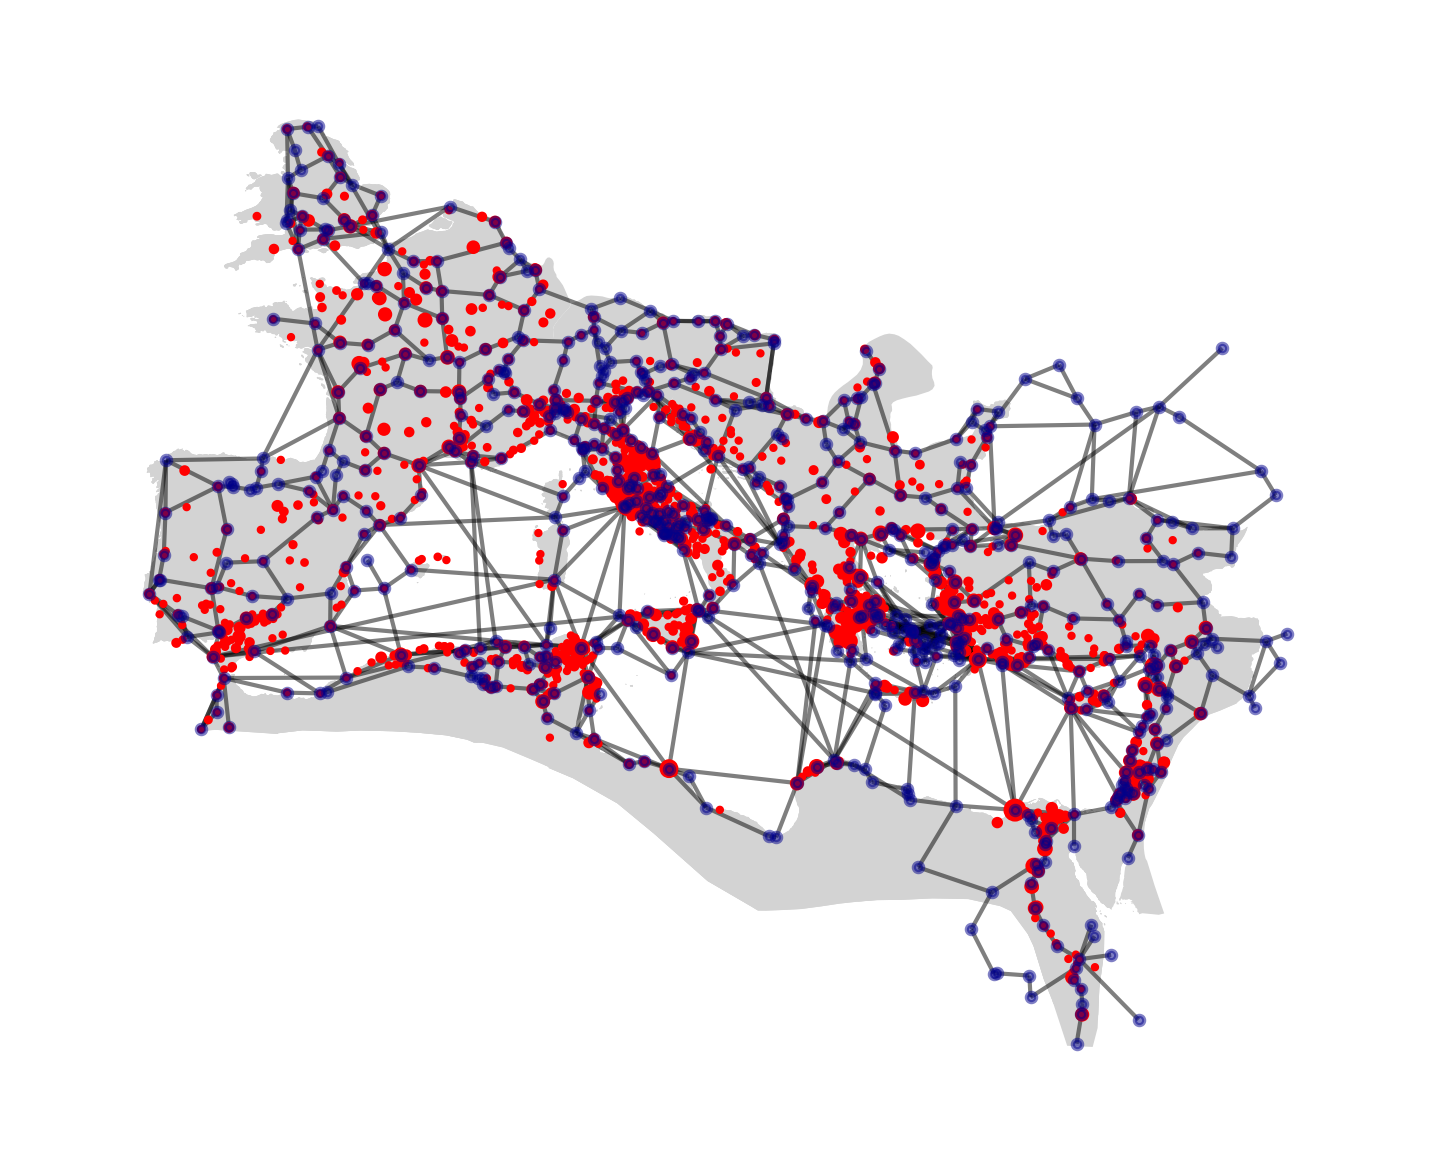

In [102]:
# save for future usage
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=[5.2, 4], tight_layout=True)
markersizes = np.sqrt(np.array(roman_cities["pop_est"].tolist()) / 1000)
pleiades_regions.plot(color="lightgray", ax=ax)

#orbis_routes.plot(ax=ax, linewidth=0.4)
nx.draw(G3, positions, with_labels=False, node_size=5, node_color="darkblue", node_shape="o", alpha=0.5, linewidths=1, ax=ax)

markersizes = np.sqrt(np.array(roman_cities["pop_est"].tolist()) / 1000)
roman_cities.plot(markersize=markersizes, ax=ax, color="red")

#orbis_sites_stanford.plot(markersize=1, color="green", ax=ax, alpha=0.5)
ax.set_axis_off()


# Mapping Hanson on Orbis

In [103]:
len(np.array(list(orbis_sites_stanford.geometry.apply(lambda x: (x.x, x.y)))))

678

In [105]:
roman_cities.reset_index(drop=True, inplace=True)

nA = np.array(list(orbis_sites_stanford.geometry.apply(lambda x: (x.x, x.y))))
nB = np.array(list(roman_cities.geometry.apply(lambda x: (x.x, x.y))))

btree = cKDTree(nB)
dist, idx = btree.query(nA, k=1)

In [107]:
np.max(idx)

1386

In [109]:
len(idx)

678

In [110]:
len(roman_cities)


1388

In [111]:
roman_cities.loc[idx]

Primary Key Ancient Toponym Modern Toponym  \
1342  Hanson2016_1343        Samosata         Samsat   
1048  Hanson2016_1049       Concordia      Concordia   
991    Hanson2016_992            Roma           Rome   
182    Hanson2016_183       Macomades   Merkeb-Talha   
1058  Hanson2016_1059        Patavium          Padua   
...               ...             ...            ...   
27      Hanson2016_28           Delos          Delos   
101    Hanson2016_102           Thera          Thera   
27      Hanson2016_28           Delos          Delos   
266    Hanson2016_267          Cnidus         Cnidus   
25      Hanson2016_26       Corinthia        Corinth   

                           Province Country Barrington Atlas Rank  \
1342                          Syria  Turkey                     2   
1048  Italia (X Venetia et Histria)   Italy                     3   
991            Italia (VII Etruria)   Italy                     1   
182            Africa Proconsularis   Libya                     3   
1058  Italia (X Venetia et Histria)   Italy                     2   
...                             ...     ...                   ...   
27                           Achaea  Greece                4 or 5   
101                          Achaea  Greece                4 or 5   
27                           Achaea  Greece                4 or 5   
266                            Asia  Turkey                     3   
25                           Achaea  Greece                     1   

     Barrington Atlas Reference  Start Date  End Date  \
1342                      67 H1        -323       NaN   
1048                      40 D1         -42       NaN   
991                       43 B2        -700       NaN   
182                       37 B1         -50       NaN   
1058                      40 B2         -50       NaN   
...                         ...         ...       ...   
27                        61 A3        -700       NaN   
101                       61 A5        -600       NaN   
27                        61 A3        -700       NaN   
266                       61 F4        -700       NaN   
25                        58 D2         -44       NaN   

                                    Select Bibliography    Area  \
1342           BNP; Cohen 2006; DGRG; Jones 1937; PECS.   142.0   
1048  Beloch 1880; Cornell and Mathews 1982; de Ligt...    42.0   
991   Beloch 1886; Benario 1981; de Ligt 2012; Golvi...  1783.0   
182                           Lepelley 1979-1981; PECS.     NaN   
1058  Beloch 1880; de Ligt 2012; Golvin 1988; McEved...   130.0   
...                                                 ...     ...   
27    BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...    95.0   
101   BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...     NaN   
27    BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...    95.0   
266   BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...    58.0   
25    BNP; Boatwright 2000; Brunt 1971; Cornell and ...   241.0   

                         Estimate Basis  \
1342                              Walls   
1048               Urban grid and walls   
991           Fourteen Augustan regions   
182                                 NaN   
1058                     Inhabited area   
...                                 ...   
27                       Inhabited area   
101                                 NaN   
27                       Inhabited area   
266   Urban grid, walls, and topography   
25                           Urban grid   

                                           Civic Status  \
1342                                                NaN   
1048                                        ['Colonia']   
991                ['Capital of the Empire', 'Colonia']   
182             ['Municipium', 'Rights and privileges']   
1058                                     ['Municipium']   
...                                                 ...   
27                            ['Rights and privileges']   
101                          

In [124]:
def ckdnearest(orbis_nodes, cities):
    cities = cities[['Ancient Toponym', "ID", "pop_est", 'geometry']].reset_index(drop=True)
    cities.rename(columns={"Ancient Toponym" : "hanson_label", "ID" : "hanson_ID"}, inplace=True)
    nA = np.array(list(orbis_nodes.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = cities.iloc[idx].rename(columns={"geometry": "hanson_geo"})
    gdB_nearest = gdB_nearest.reset_index(drop=True)
    gdB_nearest["hanson_geo"] = [[geom.x, geom.y] for geom in gdB_nearest["hanson_geo"]]
    orbis_nodes = orbis_nodes.reset_index(drop=True)
    gdf = pd.concat(
        [
            orbis_nodes,
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)
    return gdf

In [125]:
orbis_hanson_gpd = ckdnearest(orbis_sites_stanford, roman_cities)

In [126]:
orbis_hanson_gpd.sort_values("dist", inplace=True, ascending=True)
orbis_hanson_gpd.head(5)

id                      label       x       y  \
521  50474              Portus Magnus  35.808  -0.266   
458  50418                     Vienna  45.524   4.878   
210  50131                    Corduba  37.884  -4.780   
319  50172                   Faventia  44.285  11.883   
109  50125  Ulpia Traiana Tricensimae  51.668   6.445   

                      geometry           hanson_label hanson_ID  pop_est  \
521  POINT (-0.26600 35.80800)          Portus Magnus      1182   1000.0   
458   POINT (4.87800 45.52400)                 Vienna       658  15332.0   
210  POINT (-4.78000 37.88400)                Corduba       336  19404.0   
319  POINT (11.88300 44.28500)               Faventia      1014   5399.0   
109   POINT (6.44500 51.66800)  Colonia Ulpia Traiana       661  14596.0   

                 hanson_geo      dist  
521  [-0.266018, 35.807917]  0.000085  
458   [4.878056, 45.524167]  0.000176  
210    [-4.78025, 37.88376]  0.000347  
319  [11.882989, 44.285348]  0.000348  
109   [6.444591, 51.668014]  0.000409

In [134]:
orbis_hanson_gpd[orbis_hanson_gpd["dist"] < 0.1].tail(10)

id          label       x       y                   geometry  \
577  50590        Sigeion  40.010  26.200  POINT (26.20000 40.01000)   
157  50376          Tabia  39.858  34.535  POINT (34.53500 39.85800)   
597  50598  Trogilion Pr.  37.670  27.020  POINT (27.02000 37.67000)   
402  50522        Aufidus  41.360  16.210  POINT (16.21000 41.36000)   
442  50757              x  46.021  23.499  POINT (23.49900 46.02100)   
559  50557    Sounion Pr.  37.650  24.030  POINT (24.03000 37.65000)   
403  50765              x  43.805  10.390  POINT (10.39000 43.80500)   
408  50732              x  43.136  17.887  POINT (17.88700 43.13600)   
269  50316     Porolissum  47.168  23.194  POINT (23.19400 47.16800)   
568  50569     Hephaistia  39.932  25.235  POINT (25.23500 39.93200)   

    hanson_label hanson_ID  pop_est                      hanson_geo      dist  
577        Ilium       288   3086.0          [26.257773, 39.953869]  0.080551  
157       Tavium       425   1000.0          [34.456374, 39.878991]  0.081380  
597        Samos       311  30829.0           [26.94006, 37.691522]  0.082786  
402       Cannae       825   1000.0  [16.151667, 41.29638900000001]  0.086308  
442   Apulum (2)       493  16831.0          [23.572315, 46.066695]  0.086389  
559     Thoricus       105   1000.0          [24.053491, 37.737524]  0.090622  
403        Pisae       987   3937.0           [10.40074, 43.714368]  0.091266  
408     Diluntum       524   1000.0          [17.958448, 43.078729]  0.091568  
269   Porolissum       497   2601.0  [23.126667, 47.23027800000001]  0.091718  
568   Hephaestia        44   4291.0           [25.324204, 39.95907]  0.093221

In [135]:
len(orbis_hanson_gpd[orbis_hanson_gpd["dist"] < 0.1])
#len(orbis_hanson_gpd[orbis_hanson_gpd["dist"] < 0.06])

436

In [136]:
len(orbis_hanson_gpd[orbis_hanson_gpd["dist"] < 0.1]["hanson_label"].unique().tolist())

429

In [167]:
def dist_filter(row, col, threshold=0.1):
    if row["dist"] < threshold:
        return row[col]
    else:
        if col == "pop_est":
            return 1000
        else:
            return None 

for col in ["hanson_label", "hanson_ID", "hanson_geo", "pop_est", "dist"]:
    orbis_hanson_gpd[col] = orbis_hanson_gpd.apply(lambda row: dist_filter(row, col), axis=1)

In [168]:
orbis_hanson_gpd.tail(5)

id        label       x       y                   geometry  \
602  50623  Kalos Limen  45.521  32.703  POINT (32.70300 45.52100)   
506  50682        Ammon  29.205  25.544  POINT (25.54400 29.20500)   
603  50651   Dioscurias  42.993  41.003  POINT (41.00300 42.99300)   
628  50652       Phasis  42.150  41.667  POINT (41.66700 42.15000)   
502  50650       Tanais  47.268  39.258  POINT (39.25800 47.26800)   

    hanson_label hanson_ID  pop_est hanson_geo  dist  
602         None      None   1000.0       None   NaN  
506         None      None   1000.0       None   NaN  
603         None      None   1000.0       None   NaN  
628         None      None   1000.0       None   NaN  
502         None      None   1000.0       None   NaN

In [179]:
used_hanson_cities = []
duplicates_ids = []
for k, row in orbis_hanson_gpd.iterrows():
    if (row["hanson_ID"] in used_hanson_cities) & (row["hanson_ID"] != None):
        duplicates_ids.append(row["id"])
    used_hanson_cities.append(row["hanson_ID"])
duplicates_ids

[50721, 50572, 50214, 50590, 50598, 50522, 50765]

In [180]:
def dupl_filter(row, col):
    if row["id"] not in duplicates_ids:
        return row[col]
    else:
        if col == "pop_est":
            return 1000
        else:
            return None 
for col in ["hanson_label", "hanson_ID", "hanson_geo", "pop_est", "dist"]:
    orbis_hanson_gpd[col] = orbis_hanson_gpd.apply(lambda row: dupl_filter(row, col), axis=1)

In [181]:
len(orbis_hanson_gpd[orbis_hanson_gpd["hanson_label"].notnull()])

429

In [182]:
orbis_hanson_gpd["pop_est"].sum()

6396976.0

In [218]:
orbis_hanson_gpd.to_pickle("../data/orbis_hanson_gpd.pickle")

In [221]:
orbis_hanson_gpd.to_parquet("../data/orbis_hanson_gpd.par")

# Map inscriptions on orbis sites

In [183]:
def ckdnearest(inscriptions, sites_gdf):
    sites_gdf = sites_gdf[["id", "geometry"]] 
    sites_gdf.rename(columns={"id" : "orbis_id"}, inplace=True)
    nA = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(sites_gdf.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = sites_gdf.iloc[idx].rename(columns={"geometry": "city_geometry"}).reset_index(drop=True)
    gdB_nearest["city_geometry"] = [[geom.x, geom.y] for geom in gdB_nearest["city_geometry"]]
    gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='orbis_site_dist')
        ], 
        axis=1)
    return gdf

#ckdnearest(gpd1, gpd2)

In [184]:
%%time
LIRE = ckdnearest(LIRE, orbis_hanson_gpd)
LIRE.head(5)

CPU times: user 6.05 s, sys: 267 ms, total: 6.32 s
Wall time: 6.32 s


EDCS-ID                                        publication province  \
0  EDCS-03700724  ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...   Achaia   
1  EDCS-03300852                                     AE 1995, 01409   Achaia   
2  EDCS-28500283  CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...   Achaia   
3  EDCS-09400671  CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...   Achaia   
4  EDCS-24600769                    AE 1995, 01407 = AE 2001, 01812   Achaia   

  province_list                                       place  \
0        Achaia                  Agios Athanasios / Photike   
1        Achaia                                Alea / Tegea   
2        Achaia                                Alea / Tegea   
3        Achaia                                      Andros   
4        Achaia  Archea Olimpia / Archaia Olympia / Olympia   

                                         place_list end_yr_list  \
0                   ['Agios Athanasios', 'Photike']         313   
1                                 ['Alea', 'Tegea']         276   
2                                 ['Alea', 'Tegea']          50   
3                                            Andros         209   
4  ['Archea Olimpia', 'Archaia Olympia', 'Olympia']          96   

                             notes_dating  \
0                                           
1  to 276;   b:  276 to 282         \n\n    
2                                           
3                                           
4                                           

                                         status_list        inscr_type  \
0  ['Augusti/Augustae', 'litterae erasae', 'ordo ...  tituli honorarii   
1           ['Augusti/Augustae', 'miliaria', 'viri']          miliaria   
2              ['Augusti/Augustae', 'leges', 'viri']             leges   
3                ['litterae erasae', 'tituli sacri']      tituli sacri   
4                                                { }               { }   

                                     status_notation    inscr_process  \
0  ['Augusti/Augustae', 'ordo equester', 'tria no...  litterae erasae   
1                       ['Augusti/Augustae', 'viri']              { }   
2                       ['Augusti/Augustae', 'viri']              { }   
3                                                { }  litterae erasae   
4                                                { }              { }   

  notes_references notes_comments  \
0                                   
1                                   
2                                   
3                                   
4                                   

                                         inscription  \
0  Fortissimo et Piis/simo Caesari d(omino) n(ost...   
1  to 276;   b:  276 to 282         \n\n \n \nImp...   
2  T[(iberius)] Claudius Caesar Aug(ustus) / G[er...   
3  Pro salute Imp(eratoris) Caesari(s) / L(uci) S...   
4                             Octa(vius) Sa(lutaris)   

                          inscription_stripped_final  \
0  Fortissimo et Piis/simo Caesari d(omino) n(ost...   
1  Imp(eratori) / Floriano / P(io) F(elici) Aug(u...   
2  T[(iberius)] Claudius Caesar Aug(ustus) / G[er...   
3  Pro salute Imp(eratoris) Caesari(s) / L(uci) S...   
4                             Octa(vius) Sa(lutaris)   

                                               Links  dating from dating to  \
0  http://db.edcs.eu/epigr/partner.php?s_language...        309.0       313   
1  http://db.edcs.eu/epigr/partner.php?s_language...          NaN       276   
2  http://db.edcs.eu/epigr/partner.php?s_language...         49.0        50   
3  http://db.edcs.eu/epigr/partner.php?s_language...        198.0       209   
4  http://db.edcs.eu/epigr/partner.php?s_language...         81.0        96   

                                              status   Latitude  Longitude  \
0  Augusti/Augustae; litterae erasae; ordo equest...  39.451218  20.766767   
1                   Augusti/Augustae; miliaria; viri  37.454501

In [204]:
# testing overlap between two intervals
# len 0 = no overlap
# len 1 = overlap
not_before, not_after = 0, 300
period_start, period_end = 101, 200
len(interval[period_start, period_end] & interval[not_before, not_after])

TypeError: 'module' object is not subscriptable

In [ ]:
interval()

In [79]:
def temporal_overlap(period_start, period_end, inscr_start, inscr_end):
    if np.isnan(inscr_start):
        inscr_start = inscr_end
    if np.isnan(inscr_end):
        inscr_end = inscr_start
    if len(interval[period_start, period_end] & interval[inscr_start, inscr_end]) > 0:
        return True
    else:
        return False

In [80]:
LIRE_period1 = LIRE[LIRE.apply(lambda row: temporal_overlap(1, 100, row["not_before"], row["not_after"]), axis=1)] 
LIRE_period2 = LIRE[LIRE.apply(lambda row: temporal_overlap(101, 200, row["not_before"], row["not_after"]), axis=1)] 
LIRE_period3 = LIRE[LIRE.apply(lambda row: temporal_overlap(201, 300, row["not_before"], row["not_after"]), axis=1)] 

In [81]:
for per in [LIRE_period1, LIRE_period2, LIRE_period3]:
    print(len(per))

56000
67838
43973


In [83]:
def get_inscr_ids(orbis_id, source, LIRE_period):
    LIRE_subset = LIRE_period[LIRE_period["orbis_id"]==orbis_id]
    if source == "EDCS":
        ids = LIRE_subset[LIRE_subset["EDCS-ID"].notnull() & LIRE_subset["EDH-ID"].isnull()]["EDCS-ID"].tolist()
    else:
        ids = LIRE_subset[LIRE_subset["EDH-ID"].notnull()]["EDH-ID"].tolist()
    return ids

In [84]:
get_inscr_ids(50474, "EDH", LIRE_period3)

['HD033385',
 'HD000463',
 'HD052542',
 'HD033325',
 'HD033415',
 'HD033388',
 'HD030633']

In [85]:
orbis_hanson_gpd.head(5)

id                      label  rank       x       y  cost  target  \
465  50474              Portus Magnus    70  -0.266  35.808     0       0   
411  50418                     Vienna    90   4.878  45.524     0       0   
126  50131                    Corduba   100  -4.780  37.884     0       0   
167  50172                   Faventia    70  11.883  44.285     0       0   
120  50125  Ulpia Traiana Tricensimae    80   6.445  51.668     0       0   

                    province   modern                   geometry  \
465  Mauretania Caesariensis  Algeria  POINT (-0.26600 35.80800)   
411              Narbonensis   France   POINT (4.87800 45.52400)   
126                  Baetica    Spain  POINT (-4.78000 37.88400)   
167                   Italia    Italy  POINT (11.88300 44.28500)   
120        Germania Inferior  Germany   POINT (6.44500 51.66800)   

              hanson_label hanson_ID  pop_est              hanson_geo  \
465          Portus Magnus      1182   1000.0  [-0.266018, 35.807917]   
411                 Vienna       658  15332.0   [4.878056, 45.524167]   
126                Corduba       336  19404.0    [-4.78025, 37.88376]   
167               Faventia      1014   5399.0  [11.882989, 44.285348]   
120  Colonia Ulpia Traiana       661  14596.0   [6.444591, 51.668014]   

         dist  
465  0.000085  
411  0.000176  
126  0.000347  
167  0.000348  
120  0.000409

In [86]:
orbis_hanson_gpd["EDH_all"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE))
orbis_hanson_gpd["EDCS_all"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE))

In [87]:
orbis_hanson_gpd["LIRE_total_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_all"])+len(row["EDCS_all"]), axis=1)

In [88]:
orbis_hanson_gpd.sort_values("pop_est", ascending=False).head(5)

id         label  rank       x       y  cost  target  province  \
321  50327          Roma   100  12.485  41.891     0       0    Italia   
16   50017    Alexandria   100  29.910  31.200     0       0  Aegyptus   
225  50230  Lepcis Magna   100  14.292  32.637     0       0    Africa   
550  50613        Rhodos    80  28.230  36.440     0       0      Asia   
22   50024     Antiochia   100  36.169  36.208     0       0     Syria   

     modern                   geometry           hanson_label hanson_ID  \
321   Italy  POINT (12.48500 41.89100)                   Roma       992   
16    Egypt  POINT (29.91000 31.20000)  Alexandria (Aegyptus)       110   
225   Libya  POINT (14.29200 32.63700)           Lepcis Magna       180   
550  Greece  POINT (28.23000 36.44000)                 Rhodus       309   
22   Turkey  POINT (36.16900 36.20800)      Antiochia (Syria)      1324   

      pop_est              hanson_geo      dist  \
321  923313.0  [12.485098, 41.892777]  0.001780   
16   410502.0  [29.903728, 31.195024]  0.008006   
225  153722.0    [14.29306, 32.63833]  0.001701   
550  130398.0  [28.227007, 36.443235]  0.004407   
22   124930.0  [36.169629, 36.210172]  0.002261   

                                               EDH_all  \
321  [HD016234, HD007300, HD006780, HD016689, HD002...   
16   [HD025477, HD017883, HD032199, HD045448, HD019...   
225  [HD021906, HD045234, HD045235, HD018125, HD021...   
550                                                 []   
22                                          [HD061603]   

                                              EDCS_all  LIRE_total_N  
321  [EDCS-22700240, EDCS-22700241, EDCS-22700242, ...         38647  
16   [EDCS-71300297, EDCS-58200213, EDCS-20800415, ...            37  
225  [EDCS-51500074, EDCS-51500075, EDCS-51500076, ...           319  
550                                    [EDCS-70200274]             1  
22                                                  []             1

In [89]:
%%time
orbis_hanson_gpd["EDH_per1"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period1))
orbis_hanson_gpd["EDCS_per1"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period1))

orbis_hanson_gpd["EDH_per2"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period2))
orbis_hanson_gpd["EDCS_per2"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period2))

orbis_hanson_gpd["EDH_per3"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period3))
orbis_hanson_gpd["EDCS_per3"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period3))

CPU times: user 9min 1s, sys: 4.11 s, total: 9min 5s
Wall time: 9min 5s


In [90]:
orbis_hanson_gpd["LIRE_per1_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per1"])+len(row["EDCS_per1"]), axis=1)
orbis_hanson_gpd["LIRE_per2_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per2"])+len(row["EDCS_per2"]), axis=1)
orbis_hanson_gpd["LIRE_per3_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per3"])+len(row["EDCS_per3"]), axis=1)

In [91]:
orbis_hanson_gpd.head(5)

id                      label  rank       x       y  cost  target  \
465  50474              Portus Magnus    70  -0.266  35.808     0       0   
411  50418                     Vienna    90   4.878  45.524     0       0   
126  50131                    Corduba   100  -4.780  37.884     0       0   
167  50172                   Faventia    70  11.883  44.285     0       0   
120  50125  Ulpia Traiana Tricensimae    80   6.445  51.668     0       0   

                    province   modern                   geometry  \
465  Mauretania Caesariensis  Algeria  POINT (-0.26600 35.80800)   
411              Narbonensis   France   POINT (4.87800 45.52400)   
126                  Baetica    Spain  POINT (-4.78000 37.88400)   
167                   Italia    Italy  POINT (11.88300 44.28500)   
120        Germania Inferior  Germany   POINT (6.44500 51.66800)   

              hanson_label hanson_ID  pop_est              hanson_geo  \
465          Portus Magnus      1182   1000.0  [-0.266018, 35.807917]   
411                 Vienna       658  15332.0   [4.878056, 45.524167]   
126                Corduba       336  19404.0    [-4.78025, 37.88376]   
167               Faventia      1014   5399.0  [11.882989, 44.285348]   
120  Colonia Ulpia Traiana       661  14596.0   [6.444591, 51.668014]   

         dist                                            EDH_all  \
465  0.000085  [HD047307, HD033385, HD000463, HD052542, HD033...   
411  0.000176  [HD052078, HD052079, HD001171, HD001626, HD001...   
126  0.000347  [HD006608, HD006605, HD006602, HD006599, HD000...   
167  0.000348  [HD017246, HD016084, HD018809, HD008967, HD032...   
120  0.000409  [HD031155, HD050305, HD050306, HD050307, HD022...   

                                              EDCS_all  LIRE_total_N  \
465  [EDCS-75300340, EDCS-25500569, EDCS-25500582, ...            16   
411  [EDCS-09200591, EDCS-09200592, EDCS-09500338, ...           119   
126  [EDCS-72600014, EDCS-72600015, EDCS-75900070, ...          1290   
167  [EDCS-64901116, EDCS-30200030, EDCS-30400520, ...           102   
120  [EDCS-78300132, EDCS-78300660, EDCS-72700161, ...           424   

                                              EDH_per1  \
465                                                 []   
411  [HD001171, HD001626, HD001620, HD001623, HD049...   
126  [HD006599, HD000035, HD028010, HD013569, HD028...   
167  [HD018809, HD032458, HD005009, HD003863, HD003...   
120  [HD050305, HD050306, HD040731, HD040731, HD040...   

                                             EDCS_per1  \
465                                    [EDCS-25500582]   
411  [EDCS-09200592, EDCS-09200607, EDCS-09200608, ...   
126  [EDCS-72600014, EDCS-75900070, EDCS-75900071, ...   
167  [EDCS-04900283, EDCS-04900288, EDCS-20402028, ...   
120  [EDCS-78300132, EDCS-78300660, EDCS-72700161, ...   

                                              EDH_per2  \
465                                                 []   
411  [HD052078, HD052079, HD001617, HD052073, HD050...   
126  [HD006608, HD006605, HD006602, HD006599, HD000...   
167  [HD017246, HD016084, HD018809, HD008967, HD010...   
120  [HD031155, HD050305, HD050307, HD022736, HD022...   

                                             EDCS_per2  \
465                                    [EDCS-25500569]   
411  [EDCS-09200591, EDCS-09200607, EDCS-09200608, ...   
126  [EDCS-72600015, EDCS-73900025, EDCS-76900064, ...   
167  [EDCS-30200030, EDCS-30400520, EDCS-31200405, ...   
120  [EDCS-72700161, EDCS-72700161, EDCS-76400130, ...   

                                              EDH_per3  \
465  [HD033385, HD000463, HD052542, HD033325, HD033...   
411                     [HD001617, HD050227, HD053527]   
126  [HD006602, HD031526, HD030365, HD030401, HD030...   
167                               [HD018809, HD010890]   
120  [HD031155, HD040405, HD040405, HD040353, HD040...   

                                             EDCS_per3  LIRE_per1_N  \
465      [EDCS-25500560, EDCS-26800812,

In [42]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [101]:
pd.DataFrame(orbis_hanson_gpd).drop(["geometry"], axis=1)

id                      label  rank       x       y  cost  target  \
465  50474              Portus Magnus    70  -0.266  35.808     0       0   
411  50418                     Vienna    90   4.878  45.524     0       0   
126  50131                    Corduba   100  -4.780  37.884     0       0   
167  50172                   Faventia    70  11.883  44.285     0       0   
120  50125  Ulpia Traiana Tricensimae    80   6.445  51.668     0       0   
..     ...                        ...   ...     ...     ...   ...     ...   
558  50623                Kalos Limen    80  32.703  45.521     0       0   
589  50682                      Ammon    80  25.544  29.205     0       0   
580  50651                 Dioscurias    90  41.003  42.993     0       0   
581  50652                     Phasis    80  41.667  42.150     0       0   
579  50650                     Tanais    80  39.258  47.268     0       0   

                    province   modern           hanson_label hanson_ID  \
465  Mauretania Caesariensis  Algeria          Portus Magnus      1182   
411              Narbonensis   France                 Vienna       658   
126                  Baetica    Spain                Corduba       336   
167                   Italia    Italy               Faventia      1014   
120        Germania Inferior  Germany  Colonia Ulpia Traiana       661   
..                       ...      ...                    ...       ...   
558         Outside_Blacksea  Ukraine                   None      None   
589                 Aegyptus    Egypt                   None      None   
580         Outside_Blacksea  Georgia                   None      None   
581         Outside_Blacksea  Georgia                   None      None   
579         Outside_Blacksea   Russia                   None      None   

     pop_est              hanson_geo      dist  \
465   1000.0  [-0.266018, 35.807917]  0.000085   
411  15332.0   [4.878056, 45.524167]  0.000176   
126  19404.0    [-4.78025, 37.88376]  0.000347   
167   5399.0  [11.882989, 44.285348]  0.000348   
120  14596.0   [6.444591, 51.668014]  0.000409   
..       ...                     ...       ...   
558   1000.0                    None       NaN   
589   1000.0                    None       NaN   
580   1000.0                    None       NaN   
581   1000.0                    None       NaN   
579   1000.0                    None       NaN   

                                               EDH_all  \
465  [HD047307, HD033385, HD000463, HD052542, HD033...   
411  [HD052078, HD052079, HD001171, HD001626, HD001...   
126  [HD006608, HD006605, HD006602, HD006599, HD000...   
167  [HD017246, HD016084, HD018809, HD008967, HD032...   
120  [HD031155, HD050305, HD050306, HD050307, HD022...   
..                                                 ...   
558                                                 []   
589                                                 []   
580                                                 []   
581                                                 []   
579                                                 []   

                                              EDCS_all  LIRE_total_N  \
465  [EDCS-75300340, EDCS-25500569, EDCS-25500582, ...            16   
411  [EDCS-09200591, EDCS-09200592, EDCS-09500338, ...           119   
126  [EDCS-72600014, EDCS-72600015, EDCS-75900070, ...          1290   
167  [EDCS-64901116, EDCS-30200030, EDCS-30400520, ...           102   
120  [EDCS-78300132, EDCS-78300660, EDCS-72700161, ...           424   
..                                                 ...           ...   
558                                                 []             0   
589                                                 []             0   
580                                                 []             0   
581                                                 []             0   
579                                                 []             0   

                               

In [102]:
# save it as json (you have to drop the geometry first)
s.write_file("SDAM_data/urban/orbis_hanson.json", pd.DataFrame(orbis_hanson_gpd).drop(["geometry"], axis=1))

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson.json"


In [94]:
# save as geojson (be careful in reading back)
s.write_file("SDAM_data/urban/orbis_hanson.geojson", orbis_hanson_gpd)

A file with the same name ("orbis_hanson.geojson") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'geopandas.geodataframe.GeoDataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson.geojson"


In [95]:
# save as csv (be careful in reading back)
s.write_file("SDAM_data/urban/orbis_hanson.csv", orbis_hanson_gpd)

A file with the same name ("orbis_hanson.csv") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'geopandas.geodataframe.GeoDataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson.csv"


In [96]:
# save locally as csv
orbis_hanson_gpd.to_csv("../data/orbis_hanson.csv")